In [5]:
import os 
import pickle
from tqdm.auto import tqdm
import math
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

from utils_eval import dict_load, dict_save

In [6]:
import umap
from scipy import stats
from scipy.stats import spearmanr

In [7]:
ae_model = 'autoencoder-simple_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd'

latent_model = 'latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_transformer-6_withMask_gt_len-mha_Faster_100steps'
latent_path = '../../Results/latentDiff_updated_eval/%s/' % latent_model

In [8]:
length_dict = dict_load('../../Data/Processed/CATH_forLatentDiff/protein_length.pkl')

## Consist Seq-Struc

**Natural Samples**

In [138]:
recovery_dict = dict_load('../../Results/autoencoder/ModalityRecovery/autoencoder-simple_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd/autoencoder-simple_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_test_epo45.pkl')
consist_seq_dict = dict_load('../../Results/autoencoder/samples/autoencoder-simple_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd/foldability_autoencoder-simple_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_test_epo45.pkl')
consist_stru_dict = dict_load('../../Results/autoencoder/samples/autoencoder-simple_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd/consist-struc_autoencoder-simple_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_test_epo45.pkl')

In [145]:
print(recovery_dict['id']['3BJO_A-2-100'])
print(consist_seq_dict['3BJO_A-2-100'])
print(consist_stru_dict['3BJO_A-2-100'])

{'SI': 0.9509803921568627, 'TM-score': 0.93874, 'RMSD': 0.97}
[0.45098039215686275, 0.47058823529411764, 0.45098039215686275, 0.49019607843137253, 0.46078431372549017, 0.4411764705882353, 0.4019607843137255, 0.49019607843137253, 0.4803921568627451, 0.47058823529411764]
{'3BJO_A-2-100': (0.98972, 0.39)}


In [148]:
### collect the results
result_dict = {}

# recovery 
for dset in ['id', 'od']:
    for sample in recovery_dict[dset]:
        result_dict[sample] = recovery_dict[dset][sample]

# consist-seq
for sample in consist_seq_dict:
    if sample not in result_dict:
        result_dict[sample] = {}
    result_dict[sample]['consist-seq'] = np.mean(consist_seq_dict[sample])

# consist-struc
for sample in consist_stru_dict:
    if sample not in result_dict:
        result_dict[sample] = {}
    result_dict[sample]['consist-stru'] = consist_stru_dict[sample][sample][0]
    result_dict[sample]['consist-stru-rmsd'] = consist_stru_dict[sample][sample][1]
    

In [149]:
result_dict[sample].keys()

dict_keys(['SI', 'TM-score', 'RMSD', 'consist-seq', 'consist-stru', 'consist-stru-rmsd'])

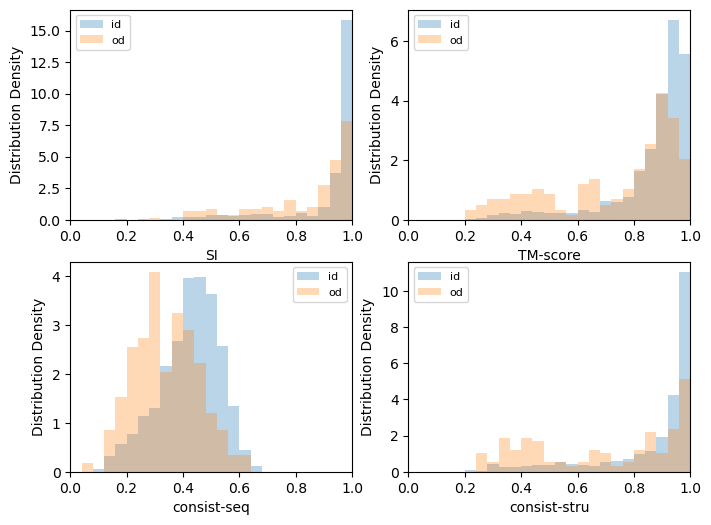

In [154]:
plt.figure(figsize = (8, 6))

for i, metric in enumerate(['SI', 'TM-score', 'consist-seq', 'consist-stru']):
    plt.subplot(2, 2, i+1)
    plt.xlim(0, 1)
    
    val_list_id = [result_dict[sample][metric] 
        for sample in result_dict if metric in result_dict[sample] and sample in recovery_dict['id']
    ]
    val_list_od = [result_dict[sample][metric] 
        for sample in result_dict if metric in result_dict[sample] and sample in recovery_dict['od']
    ]
    
    plt.hist(val_list_id, bins = [x * 0.01 for x in range(0, 101, 4)], density = True, alpha = 0.3, label = 'id')
    plt.hist(val_list_od, bins = [x * 0.01 for x in range(0, 101, 4)], density = True, alpha = 0.3, label = 'od')
    
    plt.xlabel(metric, fontsize = 10)
    plt.ylabel('Distribution Density', fontsize = 10)
    plt.legend(fontsize = 8)

plt.show()

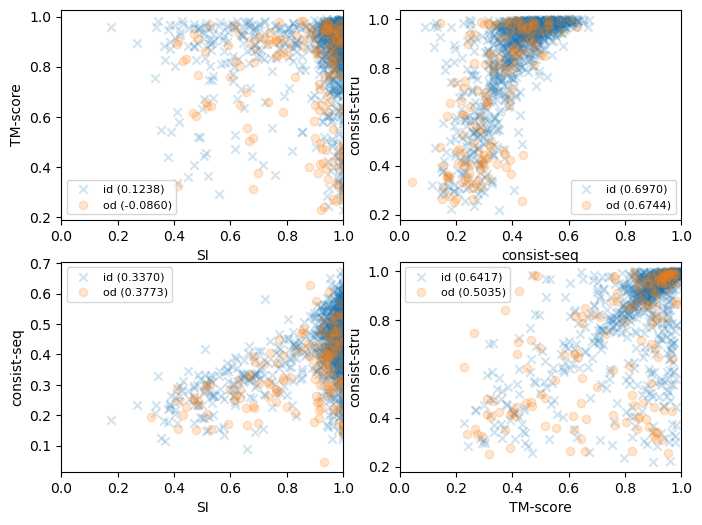

In [164]:
plt.figure(figsize = (8, 6))

for i, pair in enumerate([
    ('SI', 'TM-score'), ('consist-seq', 'consist-stru'), ('SI', 'consist-seq'), ('TM-score', 'consist-stru')
]):
    plt.subplot(2, 2, i+1)
    plt.xlim(0, 1)

    metric_1, metric_2 = pair
    
    val_list_1_id = [result_dict[sample][metric_1] 
        for sample in result_dict if metric_1 in result_dict[sample] and sample in recovery_dict['id']
    ]
    val_list_2_id = [result_dict[sample][metric_2] 
        for sample in result_dict if metric_2 in result_dict[sample] and sample in recovery_dict['id']
    ]
    
    val_list_1_od = [result_dict[sample][metric_1] 
        for sample in result_dict if metric_1 in result_dict[sample] and sample in recovery_dict['od']
    ]
    val_list_2_od = [result_dict[sample][metric_2] 
        for sample in result_dict if metric_2 in result_dict[sample] and sample in recovery_dict['od']
    ]

    res = stats.spearmanr(val_list_1_id, val_list_2_id)
    spr = res.statistic
    plt.scatter(val_list_1_id, val_list_2_id, alpha = 0.2, label = 'id (%.4f)' % spr, marker = 'x')

    res = stats.spearmanr(val_list_1_od, val_list_2_od)
    spr = res.statistic
    plt.scatter(val_list_1_od, val_list_2_od, alpha = 0.2, label = 'od (%.4f)' % spr, marker = 'o')
    
    plt.xlabel(metric_1, fontsize = 10)
    plt.ylabel(metric_2, fontsize = 10)
    plt.legend(fontsize = 8)

plt.show()

**Generated Samples**

In [174]:
gen_consist_seq_dict = dict_load('../../Results/latentDiff_updated_eval/latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_transformer-6_withMask_gt_len-mha_Faster_100steps/consistency-seq_dict.pkl')
gen_consist_stru_dict = dict_load('../../Results/latentDiff_updated_eval/latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_transformer-6_withMask_gt_len-mha_Faster_100steps/consistency-struc_dict.pkl')

foldability_dict = dict_load('../../Results/latentDiff_updated_eval/latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_transformer-6_withMask_gt_len-mha_Faster_100steps/seq_foldability.pkl')
designability_dict = dict_load('../../Results/latentDiff_updated_eval/latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_transformer-6_withMask_gt_len-mha_Faster_100steps/designability_dict.pkl')

In [177]:
result_gen_dict = {}

for sample in gen_consist_seq_dict:
    result_gen_dict[sample] = {'consist-seq': np.mean(gen_consist_seq_dict[sample])}

for sample in gen_consist_stru_dict:
    if sample not in result_gen_dict:
        result_gen_dict[sample] = {}
    result_gen_dict[sample]['consist-stru'] = gen_consist_stru_dict[sample][sample][0]

for sample in foldability_dict:
    if sample not in result_gen_dict:
        result_gen_dict[sample] = {}
    result_gen_dict[sample]['foldability'] = np.mean(foldability_dict[sample])

for sample in designability_dict:
    if sample not in result_gen_dict:
        result_gen_dict[sample] = {}
    result_gen_dict[sample]['designability'] = np.mean([designability_dict[sample][sample_2][0] for sample_2 in designability_dict[sample]])

consist-seq 0.46181414253547803
consist-stru 0.42578830662983425
foldability 0.3164080625494845
designability 0.5350033459459459


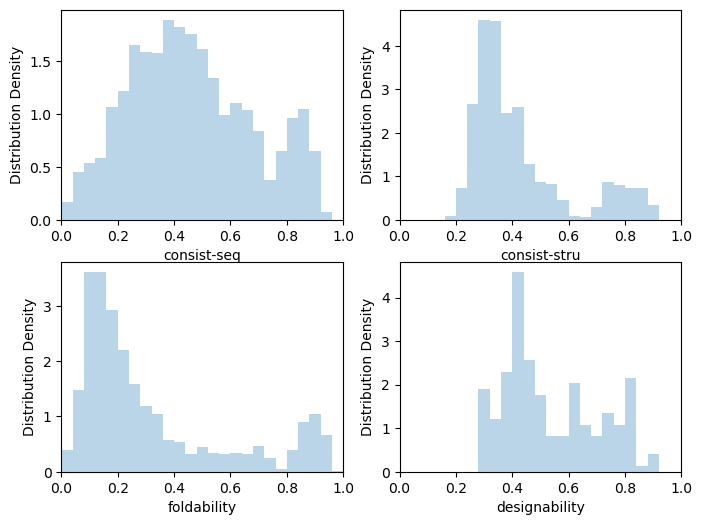

In [183]:
plt.figure(figsize = (8, 6))

for i, metric in enumerate(['consist-seq', 'consist-stru', 'foldability', 'designability']):
    plt.subplot(2, 2, i+1)
    plt.xlim(0, 1)
    
    val_list = [result_gen_dict[sample][metric] 
        for sample in result_gen_dict if metric in result_gen_dict[sample]
    ]
    print(metric, np.mean(val_list))
    plt.hist(val_list, bins = [x * 0.01 for x in range(0, 101, 4)], density = True, alpha = 0.3)

    plt.xlabel(metric, fontsize = 10)
    plt.ylabel('Distribution Density', fontsize = 10)

plt.show()

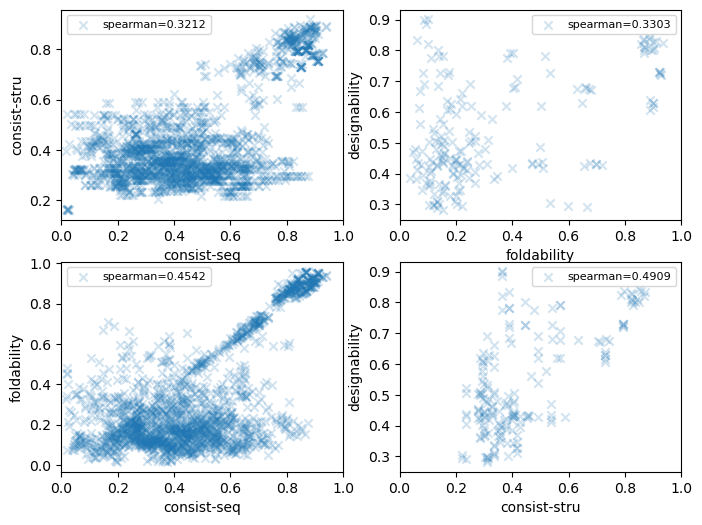

In [185]:
plt.figure(figsize = (8, 6))

for i, pair in enumerate([
    ('consist-seq', 'consist-stru'), ('foldability', 'designability'), ('consist-seq', 'foldability'), ('consist-stru', 'designability')
]):
    plt.subplot(2, 2, i+1)
    plt.xlim(0, 1)

    metric_1, metric_2 = pair
    
    val_list_1 = [result_gen_dict[sample][metric_1] 
        for sample in result_gen_dict if metric_1 in result_gen_dict[sample] and metric_2 in result_gen_dict[sample]
    ]
    val_list_2 = [result_gen_dict[sample][metric_2] 
        for sample in result_gen_dict if metric_2 in result_gen_dict[sample] and metric_1 in result_gen_dict[sample]
    ]

    res = stats.spearmanr(val_list_1, val_list_2)
    spr = res.statistic
    plt.scatter(val_list_1, val_list_2, alpha = 0.2, label = 'spearman=%.4f' % spr, marker = 'x')

    
    plt.xlabel(metric_1, fontsize = 10)
    plt.ylabel(metric_2, fontsize = 10)
    plt.legend(fontsize = 8)

plt.show()

## Embedding

In [522]:
emb_list = []
name_list = []
len_list = []

In [523]:
### ae_embedding
ae_emb_path = '../../Results/autoencoder/embedding/%s/' % ae_model
dict_list = [d for d in os.listdir(ae_emb_path) if d.endswith('.pkl')]
random.shuffle(dict_list)
dict_list_sele = dict_list[:1810]

In [530]:
ae_emb = {}
for d in dict_list_sele:
    name = d[:-4]
    emb = dict_load(os.path.join(ae_emb_path, d))['node']
    l = length_dict[name]
    l_emb = math.ceil((l - 3) / 2) + 1
    emb[l_emb:] = 0
    ae_emb[name] = emb
    emb_list.append(emb)
    name_list.append(name)
    len_list.append(l)

ModuleNotFoundError: No module named 'numpy._core'

In [531]:
### latent embedding
latent_emb_path = '%s/samples/emb_gen.pkl' % latent_path
latent_emb = dict_load(latent_emb_path)

FileNotFoundError: [Errno 2] No such file or directory: '../../Results/latentDiff_updated_eval/latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_transformer-6_withMask_gt_len-mha_Faster_100steps//samples/emb_gen.pkl'

In [76]:
latent_emb[21][0][0][0]

tensor([[-1.6392, -0.9484, 12.9452,  ...,  4.2948,  4.3128,  3.5884],
        [-1.5879,  0.0536, 10.2125,  ...,  0.6578,  0.6139,  1.7930],
        [-1.7146,  0.0776,  9.9950,  ...,  0.6304,  0.5421,  2.0657],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [77]:
for l in latent_emb:
    for i, sample in enumerate(latent_emb[l]):
        emb = sample[0][0]
        emb_list.append(emb.numpy())
        name_list.append('len%d_%d' % (l, i+1))
        len_list.append(l)

In [78]:
sample_num = len(emb_list)
print(sample_num)

3620


In [79]:
distance_mat = np.zeros((sample_num, sample_num))

In [80]:
for i, emb in tqdm(enumerate(emb_list[:-1])):
    emb = emb.reshape(-1,1600)
    emb_rest = np.vstack(emb_list[i+1:]).reshape(-1, 1600)  # (N, 1600)
    d_vec = np.sqrt(np.sum(((emb_rest - emb) ** 2), axis = -1))  # (N, )
    distance_mat[i, i+1:] = d_vec

0it [00:00, ?it/s]

In [81]:
distance_mat += distance_mat.T

In [86]:
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.3, metric='precomputed')
embedding = umap_model.fit_transform(distance_mat)

/scratch/user/shaowen1994/.conda/envs/diffab/lib/python3.8/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/scratch/user/shaowen1994/.conda/envs/diffab/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [90]:
embedding.shape

(3620, 2)

In [101]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

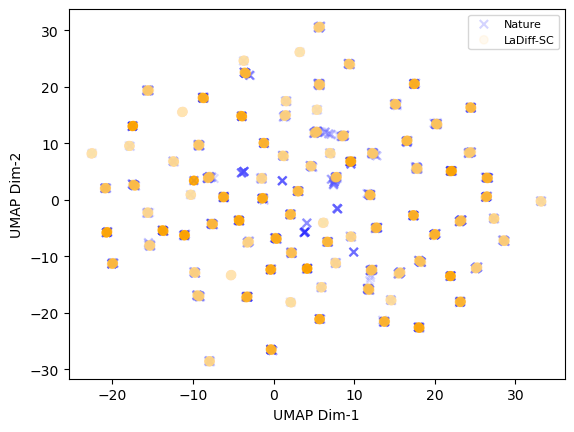

In [112]:
plt.figure()

nature_idx = [i for i in range(1810)]
gen_idx = [i for i in range(1810, 3620)]

plt.scatter(
    [embedding[i][0] for i in nature_idx], 
    [embedding[i][1] for i in nature_idx], 
    label = 'Nature', color = [lighten_color('blue', 0.3 + (len_list[i] - 20) * (0.7 /180)) for i in nature_idx], 
    marker = 'x', alpha=0.2
)
plt.scatter(
    [embedding[i][0] for i in gen_idx], 
    [embedding[i][1] for i in gen_idx],  
    label = 'LaDiff-SC', 
    color = [lighten_color('orange', 0.3 + (len_list[i] - 20) * (0.7 /180)) for i in gen_idx], 
    alpha=0.2
)

plt.xlabel('UMAP Dim-1', fontsize = 10)
plt.ylabel('UMAP Dim-2', fontsize = 10)
plt.legend(fontsize = 8)
plt.show()

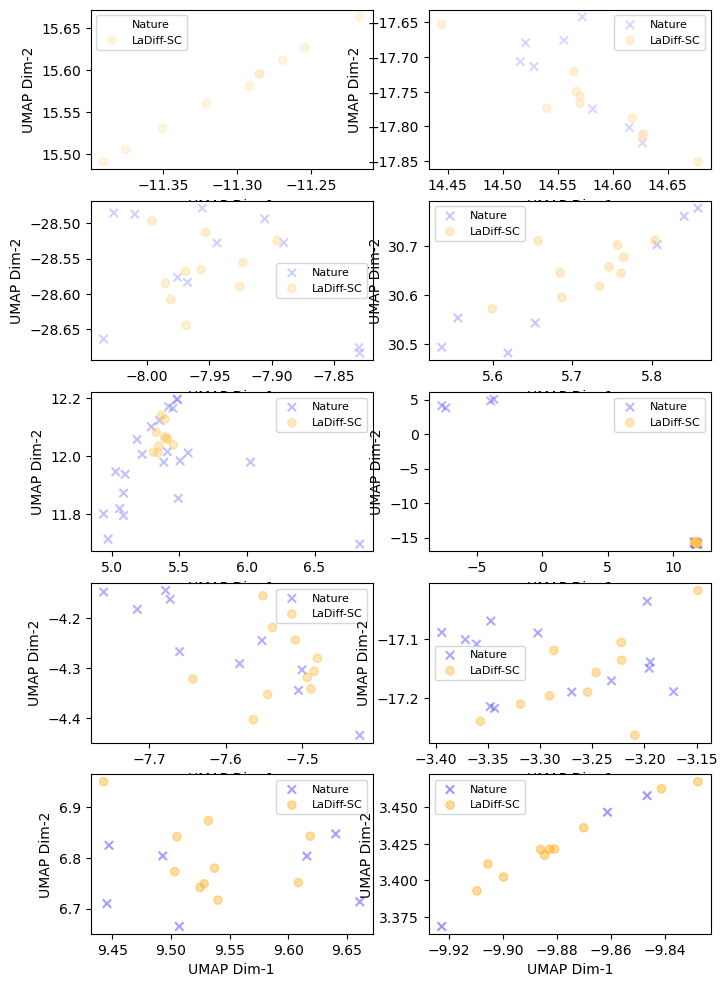

In [137]:
plt.figure(figsize = (8, 12))

for idx, l in enumerate(range(20, 201, 20)):
    plt.subplot(5, 2, idx + 1)

    nature_idx = [i for i in range(1810) if len_list[i] == l]
    gen_idx = [i for i in range(1810, 3620) if len_list[i] == l]
    
    plt.scatter(
        [embedding[i][0] for i in nature_idx], 
        [embedding[i][1] for i in nature_idx], 
        label = 'Nature', color = [lighten_color('blue', 0.3 + (len_list[i] - 20) * (0.7 /180)) for i in nature_idx], 
        marker = 'x', alpha=0.4
    )
    plt.scatter(
        [embedding[i][0] for i in gen_idx], 
        [embedding[i][1] for i in gen_idx],  
        label = 'LaDiff-SC', 
        color = [lighten_color('orange', 0.3 + (len_list[i] - 20) * (0.7 /180)) for i in gen_idx], 
        alpha=0.4
    )
    
    plt.xlabel('UMAP Dim-1', fontsize = 10)
    plt.ylabel('UMAP Dim-2', fontsize = 10)
    plt.legend(fontsize = 8)
plt.show()

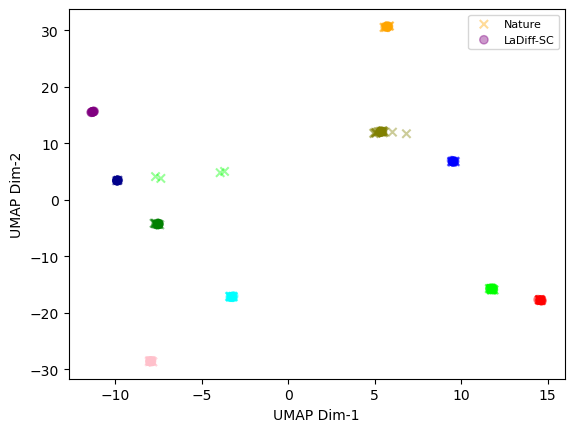

In [125]:
plt.figure()
color_list = ['purple', 'red', 'pink', 'orange', 'olive', 'lime', 'green', 'cyan', 'blue', 'darkblue']

nature_idx = [i for i in range(1810) if len_list[i] % 20 == 0]
color_list_nature = [color_list[len_list[i] // 20 - 1] for i in nature_idx]
gen_idx = [i for i in range(1810, 3620) if len_list[i] % 20 == 0]
color_list_gen = [color_list[len_list[i] // 20 - 1] for i in gen_idx]

plt.scatter(
    [embedding[i][0] for i in nature_idx], 
    [embedding[i][1] for i in nature_idx], 
    label = 'Nature', color = color_list_nature, 
    marker = 'x', alpha=0.4
)
plt.scatter(
    [embedding[i][0] for i in gen_idx], 
    [embedding[i][1] for i in gen_idx],  
    label = 'LaDiff-SC', 
    color = color_list_gen, 
    alpha=0.4
)

plt.xlabel('UMAP Dim-1', fontsize = 10)
plt.ylabel('UMAP Dim-2', fontsize = 10)
plt.legend(fontsize = 8)
plt.show()

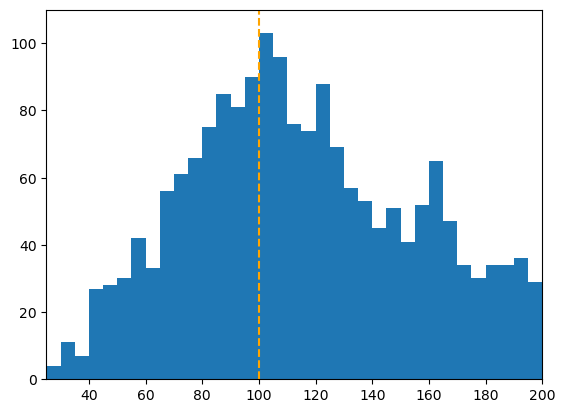

In [135]:
plt.figure()
plt.xlim(25, 200)
plt.ylim(0, 110)
plt.hist(len_list[:1810], bins = range(20, 201, 5))
plt.plot([100, 100], [0, 110], color = 'orange', linestyle = '--')
plt.show()

**Same Length**

In [521]:
emb_100 = []
name_list_100 = []
for d in dict_list:
    name = d[:-4]
    if length_dict[name] == 100:
        emb = dict_load(os.path.join(ae_emb_path, d))['node']
        l_emb = math.ceil((100 - 3) / 2) + 1
        emb[l_emb:] = 0
        emb_100.append(emb)
        name_list_100.append(name)

NameError: name 'dict_list' is not defined

In [196]:
print(len(emb_100))

526


In [197]:
emb_100_gen = dict_load('../../Results/latentDiff_updated_eval/latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_transformer-6_withMask_gt_len-mha_Faster_100steps/samples_forAnalysis/emb_gen.pkl')

In [198]:
for i, sample in enumerate(emb_100_gen[100]):
    emb = sample[0][0]
    emb_100.append(emb.numpy())

In [199]:
print(len(emb_100))

626


In [200]:
distance_mat_100 = np.zeros((len(emb_100), len(emb_100)))

for i, emb in tqdm(enumerate(emb_100[:-1])):
    emb = emb.reshape(-1,1600)
    emb_rest = np.vstack(emb_100[i+1:]).reshape(-1, 1600)  # (N, 1600)
    d_vec = np.sqrt(np.sum(((emb_rest - emb) ** 2), axis = -1))  # (N, )
    distance_mat_100[i, i+1:] = d_vec

distance_mat_100 += distance_mat_100.T

0it [00:00, ?it/s]

In [205]:
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.3, metric='precomputed')
embedding_100 = umap_model.fit_transform(distance_mat_100)

/scratch/user/shaowen1994/.conda/envs/diffab/lib/python3.8/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


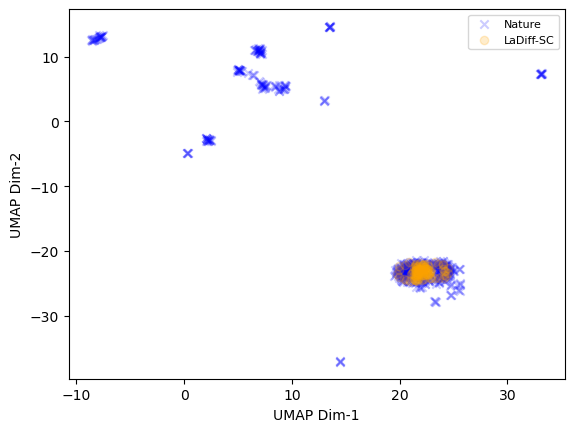

In [206]:
plt.figure()

nature_idx = [i for i in range(526)]
gen_idx = [i for i in range(526, 626)]

plt.scatter(
    [embedding_100[i][0] for i in nature_idx], 
    [embedding_100[i][1] for i in nature_idx], 
    label = 'Nature', color = 'blue',
    marker = 'x', alpha=0.2
)
plt.scatter(
    [embedding_100[i][0] for i in gen_idx], 
    [embedding_100[i][1] for i in gen_idx],  
    label = 'LaDiff-SC', color = 'orange', 
    marker = 'o', alpha=0.2
)

plt.xlabel('UMAP Dim-1', fontsize = 10)
plt.ylabel('UMAP Dim-2', fontsize = 10)
plt.legend(fontsize = 8)
plt.show()

In [210]:
for name in name_list_100:
    if name in result_dict:
        print(name, result_dict[name])

3TLR_A0-99 {'SI': 0.99, 'TM-score': 0.96891, 'RMSD': 0.68, 'consist-seq': 0.41656435643564355, 'consist-stru': 0.9867, 'consist-stru-rmsd': 0.55}
4Q2Z_A114-213 {'SI': 0.99, 'TM-score': 0.93643, 'RMSD': 1.06, 'consist-seq': 0.521, 'consist-stru': 0.98496, 'consist-stru-rmsd': 0.48}
2FSE_A82-181 {'SI': 0.97, 'TM-score': 0.97398, 'RMSD': 0.62, 'consist-seq': 0.49499999999999994, 'consist-stru': 0.99453, 'consist-stru-rmsd': 0.27}
1FZV_A18-117 {'SI': 0.8155339805825242, 'TM-score': 0.8835, 'RMSD': 1.74, 'consist-seq': 0.32199999999999995, 'consist-stru': 0.86165, 'consist-stru-rmsd': 1.63}
1YF6_L164-263 {'SI': 0.35294117647058826, 'TM-score': 0.54844, 'RMSD': 3.33, 'consist-seq': 0.12495037957974264, 'consist-stru': 0.47118, 'consist-stru-rmsd': 3.76}
1L6X_A238-337 {'SI': 1.0, 'TM-score': 0.97369, 'RMSD': 0.62, 'consist-seq': 0.4779999999999999, 'consist-stru': 0.9977, 'consist-stru-rmsd': 0.18}
1EOE_A66-165 {'SI': 0.99, 'TM-score': 0.93966, 'RMSD': 1.01, 'consist-seq': 0.52, 'consist-stru

In [220]:
emb_100_n = np.vstack([emb[:50] for emb in emb_100[:-100]])
emb_100_g = np.vstack([emb[:50] for emb in emb_100[-100:]])

In [221]:
emb_100_n_min = np.min(emb_100_n, axis = 0)
emb_100_n_max = np.max(emb_100_n, axis = 0)
emb_100_n_mean = np.mean(emb_100_n, axis = 0)

emb_100_g_min = np.min(emb_100_g, axis = 0)
emb_100_g_max = np.max(emb_100_g, axis = 0)
emb_100_g_mean = np.mean(emb_100_g, axis = 0)

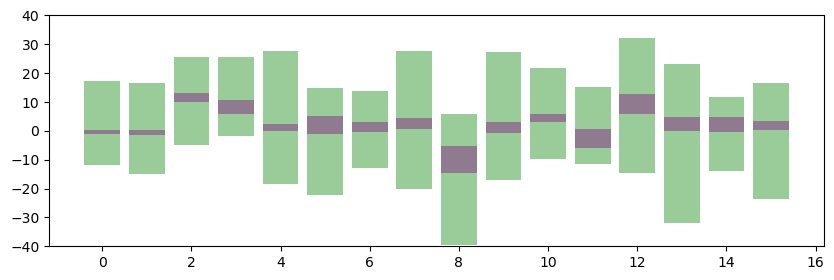

In [223]:
plt.figure(figsize=(10,3))
plt.ylim(-40, 40)
plt.bar(range(16), height = emb_100_n_max - emb_100_n_min, 
    width=0.8, bottom=emb_100_n_min, color = 'green', align='center', alpha = 0.4
)
plt.bar(range(16), height = emb_100_g_max - emb_100_g_min, 
    width=0.8, bottom=emb_100_g_min, color = 'purple', align='center', alpha = 0.4
)
plt.show()

In [230]:
print(emb_100_n_mean)
print(emb_100_g_mean)

[  0.05246246  -0.7782426   10.688959    11.05794      1.3431798
  -0.10543267   0.1977197    0.577964   -13.918037     0.5524778
   4.928084     0.06544287  12.267875     0.12991193   0.18864211
  -0.2290772 ]
[ -0.2012586   -0.2182304   10.375757    10.615726     1.2826588
  -0.05459956  -0.18986978   1.1046858  -14.187671    -0.5608838
   5.234463     0.23862597  12.402791     0.30664933   0.07660008
   0.68878853]


NameError: name 'emb_100_n_max' is not defined

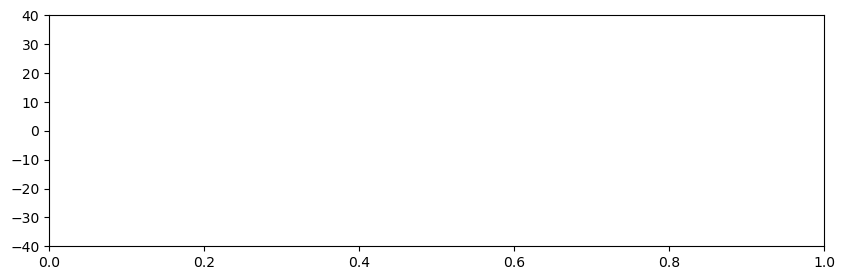

In [516]:
plt.figure(figsize=(10,3))
plt.ylim(-40, 40)
plt.bar(range(16), height = emb_100_n_max - emb_100_n_min, 
    width=0.8, bottom=emb_100_n_min, color = 'green', align='center', alpha = 0.4
)

emb_100_g_2 = emb_100_g / (emb_100_g_max - emb_100_g_min) * (emb_100_n_max - emb_100_n_min)
emb_100_g_2 = emb_100_g_2 - emb_100_g_2.min(axis=0) + emb_100_n_min

emb_100_g_min_2 = np.min(emb_100_g_2, axis = 0)
emb_100_g_max_2 = np.max(emb_100_g_2, axis = 0)
emb_100_g_mean_2 = np.mean(emb_100_g_2, axis = 0)

plt.bar(range(16), height = (emb_100_g_max_2 - emb_100_g_min_2), 
    width=0.8, bottom=emb_100_g_min_2, color = 'purple', align='center', alpha = 0.4
)
plt.show()

In [238]:
emb_100_g_2

array([[-11.712312 , -15.097757 ,  25.444775 , ...,  23.293434 ,
         11.754488 ,  16.595642 ],
       [  4.9310713,   8.015629 ,   3.5628233, ..., -20.7955   ,
         -8.264172 , -11.891156 ],
       [  7.8329096,   8.038984 ,  -3.2086153, ..., -24.323488 ,
        -11.553009 , -16.951252 ],
       ...,
       [  5.887212 ,   6.216379 ,  -3.5646029, ..., -25.747543 ,
        -12.806887 , -23.639503 ],
       [  6.3618402,   6.7482376,  -3.687337 , ..., -25.784372 ,
        -12.840454 , -23.528772 ],
       [  6.521598 ,   6.7245026,  -3.7088823, ..., -25.553082 ,
        -12.806793 , -23.530655 ]], dtype=float32)

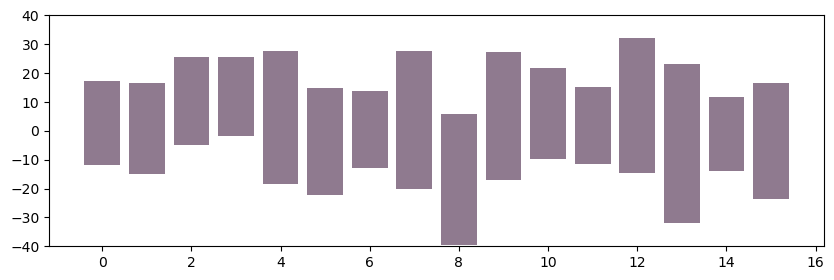

In [242]:
plt.figure(figsize=(10,3))
plt.ylim(-40, 40)
plt.bar(range(16), height = emb_100_n_max - emb_100_n_min, 
    width=0.8, bottom=emb_100_n_min, color = 'green', align='center', alpha = 0.4
)

coeff = (emb_100_n_max - emb_100_n_min) / (emb_100_g_max - emb_100_g_min)
emb_100_g_2 = emb_100_g * coeff

bias = - emb_100_g_2.min(axis=0) + emb_100_n_min
emb_100_g_2 = emb_100_g_2 + bias

emb_100_g_min_2 = np.min(emb_100_g_2, axis = 0)
emb_100_g_max_2 = np.max(emb_100_g_2, axis = 0)
emb_100_g_mean_2 = np.mean(emb_100_g_2, axis = 0)

plt.bar(range(16), height = (emb_100_g_max_2 - emb_100_g_min_2), 
    width=0.8, bottom=emb_100_g_min_2, color = 'purple', align='center', alpha = 0.4
)
plt.show()

In [243]:
print(coeff)
print(bias)

[21.174513  19.459959  10.183408   5.6260405 21.062048   6.201224
  7.4657736 12.416502   4.8971224 11.59907   10.674554   4.136931
  6.621427  11.327835   4.887371  12.882958 ]
[  11.566361   11.806135 -107.74531   -35.168335  -19.243256  -16.128742
   -9.7966    -29.101662   31.564991   -7.125759  -42.151207   12.464339
  -52.699764  -29.799826  -12.112597  -27.20396 ]


In [244]:
coeff_all = np.vstack([coeff, bias])
coeff_all

array([[  21.174513 ,   19.459959 ,   10.183408 ,    5.6260405,
          21.062048 ,    6.201224 ,    7.4657736,   12.416502 ,
           4.8971224,   11.59907  ,   10.674554 ,    4.136931 ,
           6.621427 ,   11.327835 ,    4.887371 ,   12.882958 ],
       [  11.566361 ,   11.806135 , -107.74531  ,  -35.168335 ,
         -19.243256 ,  -16.128742 ,   -9.7966   ,  -29.101662 ,
          31.564991 ,   -7.125759 ,  -42.151207 ,   12.464339 ,
         -52.699764 ,  -29.799826 ,  -12.112597 ,  -27.20396  ]],
      dtype=float32)

In [245]:
np.save('../Code_develop/coeff_debug.npy', coeff_all)

### Similar representations

In [252]:
print(len(emb_100), emb_100[0].shape)

626 (100, 16)


In [253]:
distance_mat_100.shape

(626, 626)

**Distance Mat**

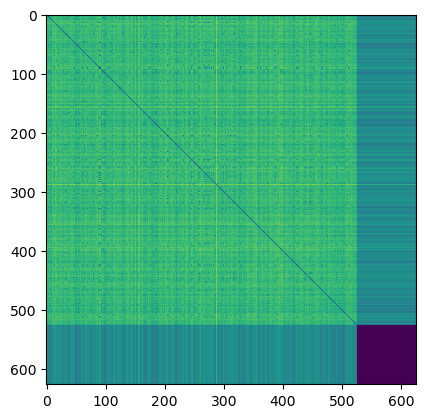

In [254]:
plt.figure()
plt.imshow(distance_mat_100)
plt.show()

**Representations**

In [ ]:
emb_100_array = np.vstack(emb_100)

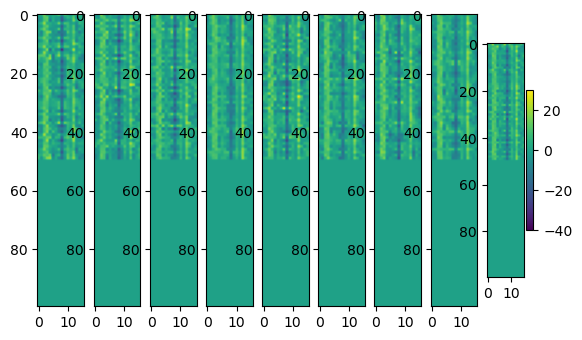

In [268]:
plt.figure()
for i in range(1, 10):
    plt.subplot(1, 9, i)
    plt.imshow(emb_100[i], vmin = -40, vmax = 30)
    if i == 9:
        plt.colorbar()
plt.show()

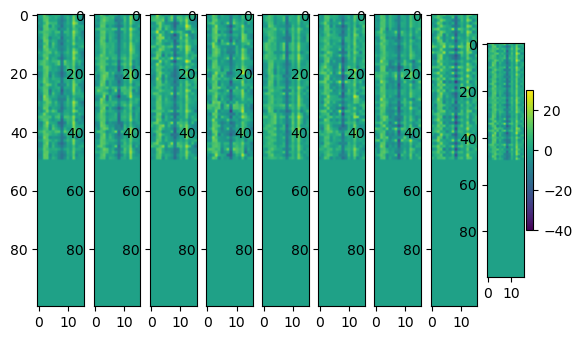

In [328]:
plt.figure()
for i in range(1, 10):
    plt.subplot(1, 9, i)
    plt.imshow(emb_100[i+50], vmin = -40, vmax = 30)
    if i == 9:
        plt.colorbar()
plt.show()

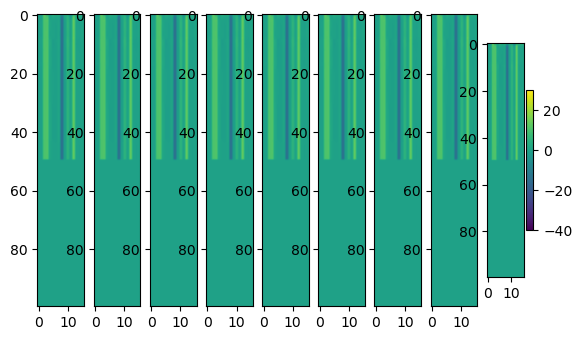

In [356]:
plt.figure()
for i in range(1, 10):
    plt.subplot(1, 9, i)
    plt.imshow(emb_100[-i], vmin = -40, vmax = 30)
    if i == 9:
        plt.colorbar()
plt.show()

In [331]:
emb

{'node_feat': tensor([[ -7.3788,  -5.1640,   1.3104,  ...,   2.9369,   8.7695,  -4.7891],
         [ -0.9992,  11.8579,   8.2143,  ...,  10.1109,   5.8909,  -4.2624],
         [ -7.4956,  -1.7401,  -0.5533,  ...,  10.4800, -15.3178,   2.7698],
         ...,
         [ 10.1036,   0.5731, -10.4709,  ...,  -0.2432,   2.5794,   2.9052],
         [  9.1341,  -0.9921, -10.6636,  ...,   2.2108,   2.1237,   3.2946],
         [  8.8901,  -1.4821, -11.0536,  ...,   3.2623,   3.9126,   3.1517]])}

In [337]:
esm_emb_path = '../../Data/Processed/CATH_forLatentDiff/esm_embed/'

In [330]:
emb = torch.load('../../Data/Processed/CATH_forLatentDiff/esm_embed/113L_A1-162.pt')

1EYS_L172-271
torch.Size([200, 1024])
2I5Z_O28-127
torch.Size([200, 1024])
2W9X_B26-132
torch.Size([200, 1024])
4HH2_B159-258
torch.Size([200, 1024])
2KDG_A-4-344
torch.Size([200, 1024])


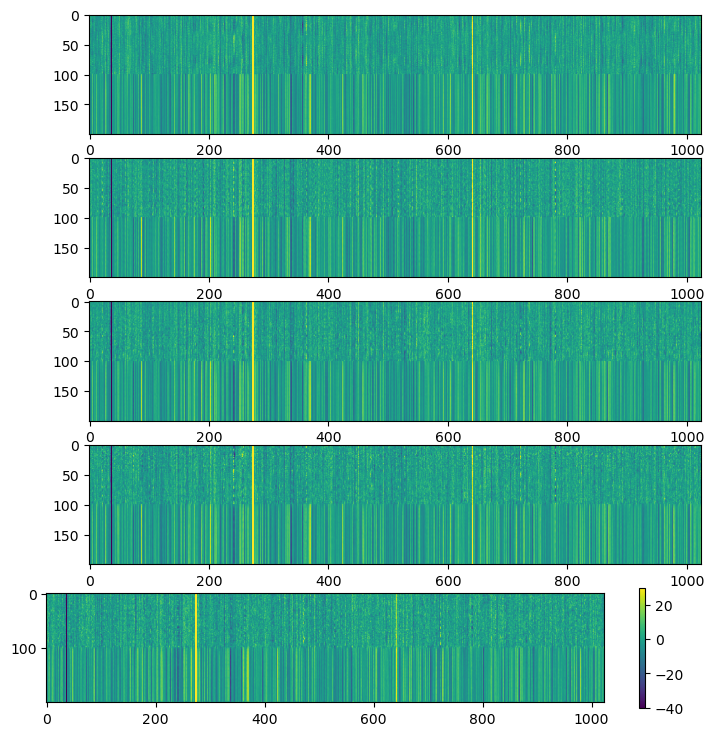

In [359]:
plt.figure(figsize = (9, 9))

for i, name in enumerate(name_list_100[50:55]):
    plt.subplot(5, 1, i+1)
    print(name)
    emb_path = os.path.join(esm_emb_path, '%s.pt' % name)
    emb = torch.load(emb_path)['node_feat']
    #emb = torch.log(emb - emb.min() + 1e-8)
    print(emb.shape)
    plt.imshow(emb, vmin = -40, vmax = 30)
    if i == 4:
        plt.colorbar()
plt.show()

In [306]:
def concat_pairs(vectors):
    """Concatenates all possible pairs of vectors in the input tensor.

    Args:
        vectors: A tensor of shape (N, D), where N is the number of vectors 
                 and D is the dimension of each vector.

    Returns:
        A tensor of shape (N * N, 2 * D), where each row represents the 
        concatenation of a pair of vectors.
    """

    # Repeat each vector N times
    repeated_vectors = vectors.repeat(vectors.shape[0], 1, 1)

    # Create a tensor of all possible combinations of indices
    indices = torch.cartesian_prod(torch.arange(vectors.shape[0]), torch.arange(vectors.shape[0]))

    # Concatenate the pairs of vectors based on the indices
    concatenated_pairs = torch.cat([repeated_vectors[indices[:, 0]], repeated_vectors[indices[:, 1]]], dim=-1)

    return concatenated_pairs

In [321]:
def concat_pairs(X):
    """Concatenates all possible pairs of vectors in the input tensor.

    Args:
        X: A tensor of shape (N, L, D).

    Returns:
        A tensor of shape (N, L, L, 2 * D), where Y[k][i][j] is the 
        concatenation of X[k][i] and X[k][j].
    """
    N, L, D = X.shape
    X_i = X.unsqueeze(2).expand(-1, -1, L, -1)  # Shape: NxLxLxD
    X_j = X.unsqueeze(1).expand(-1, L, -1, -1)  # Shape: NxLxLxD
    Y = torch.cat((X_i, X_j), dim=-1)  # Concatenate along the last dimension to get NxLxLx2D

    return Y

# Noised Representations

**Sample selection**

In [6]:
nature_emb_path = '../../Results/autoencoder/embedding/autoencoder-simple_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd/'

In [15]:
sele_length = set([20, 110, 200])
sele_dict = {l:{} for l in sele_length}

for sample in length_dict:
    l = length_dict[sample]
    sample_path = os.path.join(nature_emb_path, '%s.pkl' % (sample))
    if (l not in sele_length) or (not os.path.exists(sample_path)):
        continue

    sele_dict[l][sample] = dict_load(sample_path)['node']

In [16]:
for l in sele_dict:
    print('length=%d: %d samples.' % (l, len(sele_dict[l])))

length=200: 72 samples.
length=20: 3 samples.
length=110: 447 samples.


In [18]:
_ = dict_save(
    sele_dict, 
    '../../Results/autoencoder/embedding/autoencoder-simple_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_sele.pkl'
)

In [19]:
sele_dict[20].keys()

dict_keys(['2QR6_A-5-15', '3H25_A179-198', '4IFD_K538-557'])

In [21]:
sele_dict[20]['2QR6_A-5-15'].shape

(100, 16)

**Distance Cal**

In [38]:
kernel_size = 3

for l in sele_dict:
    l_emb = math.ceil((l - 1) / (kernel_size - 1))
    sample_list = list(sele_dict[l].keys())
    emb_list = [sele_dict[l][sample][:l_emb].reshape(-1) for sample in sample_list]
    num = len(sample_list)
    
    for i in tqdm(range(num-1)):
        tar_emb = emb_list[i]
        ref_emb = np.vstack(emb_list[i+1:])
        dist_cur = np.linalg.norm((ref_emb - tar_emb), axis = -1)

        if i == 0:
            dist_list = dist_cur
        else:
            dist_list = np.hstack([dist_list, dist_cur])
    print(l, dist_list.shape, np.mean(dist_list))
            

  0%|          | 0/71 [00:00<?, ?it/s]

200 (2556,) 281.165


  0%|          | 0/2 [00:00<?, ?it/s]

20 (3,) 53.10832


  0%|          | 0/446 [00:00<?, ?it/s]

110 (99681,) 222.4567


**Introduce Noise**

In [57]:
sele_num = 50
attempt = 5

for ratio in [0.2, 0.4, 0.6, 0.8, 1.0]:
    out_dict = {}

    for size in sele_dict:
        sample_list = list(sele_dict[size].keys())
        #sample_sele_list = random.sample(sample_list, min(sele_num, len(sample_list)))
        sample_sele_list = sample_list[:sele_num]
        out_dict[size] = []

        for sample in sample_sele_list:
            emb_ori = sele_dict[size][sample]
            for _ in range(attempt):
                noise = np.random.normal(0, 1, emb_ori.shape)
                emb_noisy = {0: (torch.from_numpy(noise * ratio + (1 - ratio) * emb_ori), None)}
                out_dict[size].append(emb_noisy)
                
    _ = dict_save(
        out_dict, 
        '../../Results/autoencoder/embedding/autoencoder-simple_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_sele_%.1fnoise.pkl' % ratio
    )

# Factor Analysis

50584 natural samples.


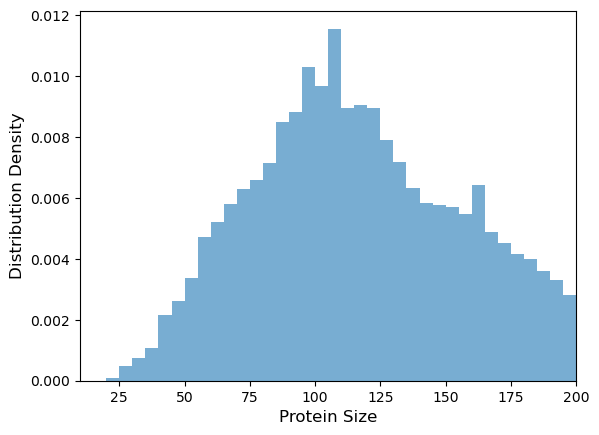

In [116]:
print('%d natural samples.' % len(length_dict))

nature_len_list = [length_dict[k] for k in length_dict]
plt.figure()
plt.xlim(10, 200)
plt.hist(nature_len_list, bins = range(20, 201, 5), density = True, alpha = 0.6)
plt.xlabel('Protein Size', fontsize = 12)
plt.ylabel('Distribution Density', fontsize = 12)
plt.show()

50584 natural samples.


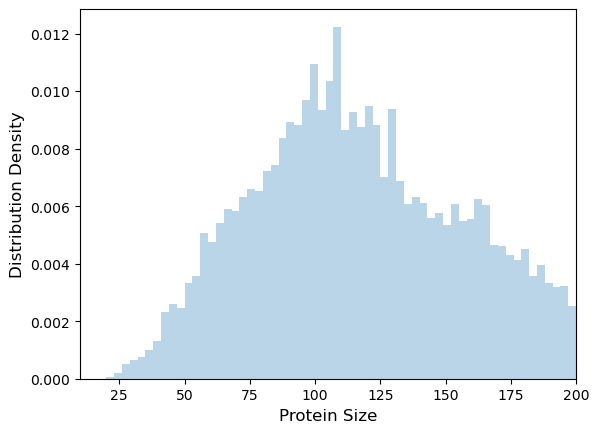

In [115]:
print('%d natural samples.' % len(length_dict))

nature_len_list = [length_dict[k] for k in length_dict]
plt.figure()
plt.xlim(10, 200)
len_contour = plt.hist(nature_len_list, bins = range(20, 201, 3), density = True, alpha = 0.3)
plt.xlabel('Protein Size', fontsize = 12)
plt.ylabel('Distribution Density', fontsize = 12)
plt.show()

In [7]:
print(len_contour)

(array([7.25239659e-05, 1.84606459e-04, 5.27447025e-04, 6.39529517e-04,
       7.71391273e-04, 1.00874243e-03, 1.31202447e-03, 2.33395308e-03,
       2.61086277e-03, 2.45922175e-03, 3.34269552e-03, 3.57345359e-03,
       5.05030526e-03, 4.74702322e-03, 5.41951818e-03, 5.90081359e-03,
       5.82828962e-03, 6.32277121e-03, 6.59968089e-03, 6.51397075e-03,
       7.21283806e-03, 7.43040996e-03, 8.35344225e-03, 8.91385471e-03,
       8.81495840e-03, 9.68524599e-03, 1.09511188e-02, 9.34899851e-03,
       1.03577409e-02, 1.22367710e-02, 8.65672429e-03, 9.25669528e-03,
       8.74243443e-03, 9.48086027e-03, 8.83473766e-03, 7.00185925e-03,
       9.38196395e-03, 6.86999749e-03, 6.07223387e-03, 6.30958503e-03,
       6.10519931e-03, 5.60412464e-03, 5.76235874e-03, 5.33380804e-03,
       6.07223387e-03, 5.47885597e-03, 5.54478685e-03, 6.23706107e-03,
       6.03926843e-03, 4.65471999e-03, 4.62834764e-03, 4.29210016e-03,
       4.13386605e-03, 4.50967206e-03, 3.58004668e-03, 3.94925960e-03,
     

In [32]:
def results_load(path = '../../Results/latentDiff_DiT/000-DiT-M-withLen/', token='_ddpm-uncon-guide_last'):

    d1 = dict_load(os.path.join(path, 'consistency-seq%s_dict.pkl' % token))
    d2 = dict_load(os.path.join(path, 'consistency-struc%s_dict.pkl' % token))
    d3 = dict_load(os.path.join(path, 'seq_foldability%s.pkl' % token))
    design_path = os.path.join(path, 'designability_esmfold%s_TMscore_dict.pkl' % token)
    if os.path.exists(design_path):
        d4 = dict_load(design_path)
    else:
        design_path = os.path.join(path, 'designability%s_dict.pkl' % token)
        d4 = dict_load(design_path)

    result_dict = {}
    name_list = ['cosist-seq', 'foldability']
    for i, d in enumerate([d1, d3]):
        name = name_list[i]
        l_list = []
        val_list = []
        val_dict = {}
        
        for sample in d:
            l = int(sample[3:].split('_')[0])
            l_list.append(l)
            val_list.append(np.mean(d[sample]))
    
        for l, val in zip(l_list, val_list):
            if l not in val_dict:
                val_dict[l] = []
            val_dict[l].append(val)
    
        result_dict[name] = (l_list, val_list, val_dict)

    name_list = ['cosist-stru', 'designability']
    for i, d in enumerate([d2, d4]):
        name = name_list[i]
        l_list = []
        val_list = []
        val_dict = {}
        
        for sample in d:
            l = int(sample[3:].split('_')[0])
            l_list.append(l)
            val_temp = [d2[sample][k][0] for k in d2[sample]]
            val_list.append(np.mean(val_temp))
    
        for l, val in zip(l_list, val_list):
            if l not in val_dict:
                val_dict[l] = []
            val_dict[l].append(val)
    
        result_dict[name] = (l_list, val_list, val_dict)

    return result_dict

In [60]:
def scatter_plot(result_dict):
    plt.figure(figsize = (10, 6))
    
    for i, name in enumerate(['cosist-seq', 'cosist-stru', 'foldability', 'designability']):
        plt.subplot(2, 2, i+1)
        plt.xlim(20, 200)
        plt.ylim(0, 1)
        plt.scatter(result_dict[name][0], result_dict[name][1], alpha = 0.3)
        plt.xlabel('Protein Size', fontsize = 12)
        plt.ylabel(name, fontsize = 12)
    
    plt.show()

In [61]:
def distribution_plot(result_dict):
    color_list = ['red', 'orange', 'pink', 'purple']
    
    plt.show()
    plt.xlim(20, 200)
    
    plt.plot([i + 2.5 for i in len_contour[1][:-1]], 50 * len_contour[0], color = 'blue', label = '50 * sample-ratio')
    
    for i, name in enumerate(['cosist-seq', 'cosist-stru', 'foldability', 'designability']):
        val_dict = result_dict[name][2]
        l_sort = sorted(val_dict.keys())
        val_mean = [np.mean(val_dict[l]) for l in l_sort]
        if len(val_mean[:-1]) == len(len_contour[0]):
            res = spearmanr(val_mean[:-1], len_contour[0])
            spr = res.statistic
            label = '%s (spr=%.3f)' % (name, spr)
        else:
            label = name
        plt.plot(l_sort, val_mean, color = color_list[i], label = label)
    
    plt.xlabel('Protein Size', fontsize = 12)
    plt.legend(fontsize = 10)
    plt.show()

### Chroma

In [62]:
result_dict = results_load(path = '../../Results/Baselines/Chroma/', token = '')

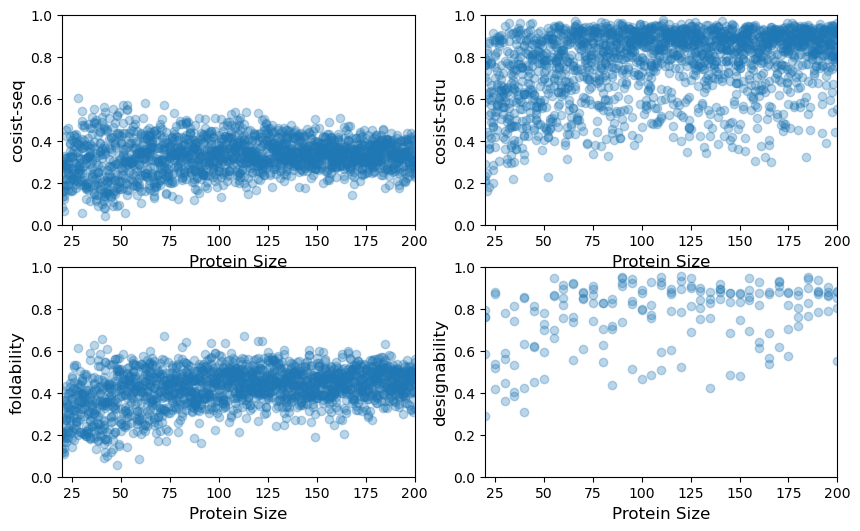

In [63]:
scatter_plot(result_dict)

In [ ]:
distribution_plot(result_dict)

### ProteinGenerator

In [64]:
result_dict = results_load(path = '../../Results/Baselines/protein_generator/', token = '')

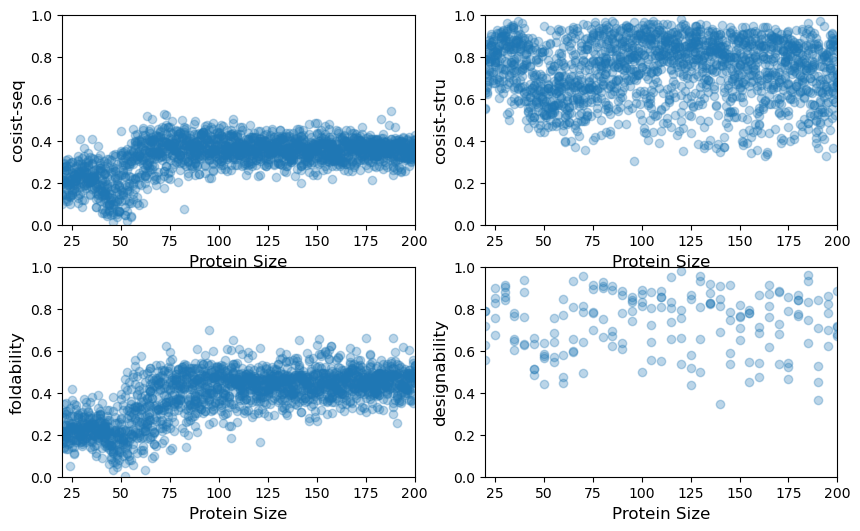

In [65]:
scatter_plot(result_dict)

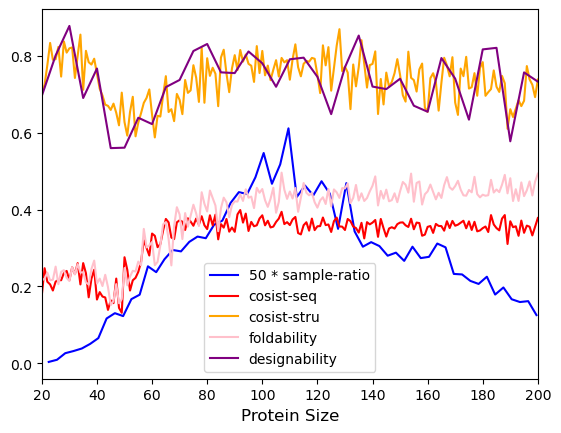

In [66]:
distribution_plot(result_dict)

### JointDiff

In [67]:
result_dict = results_load(
    path = '../../Results/Final/JointDiff/', 
    token = ''
)

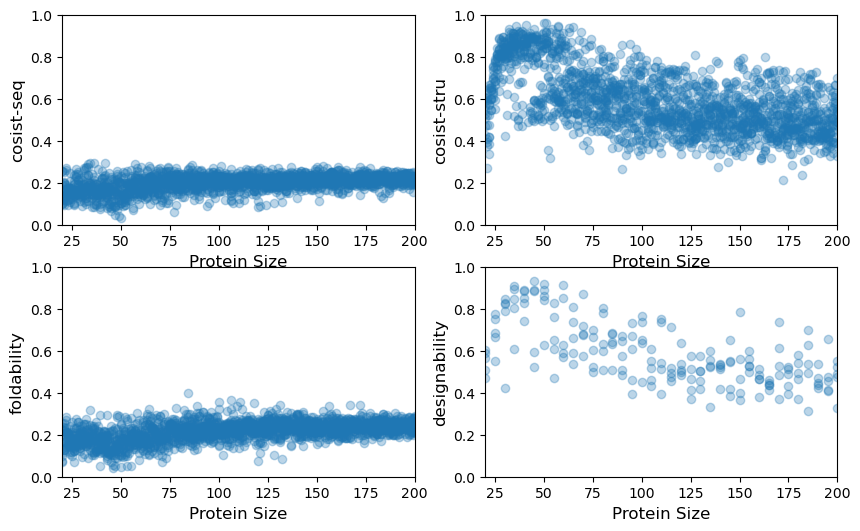

In [68]:
scatter_plot(result_dict)

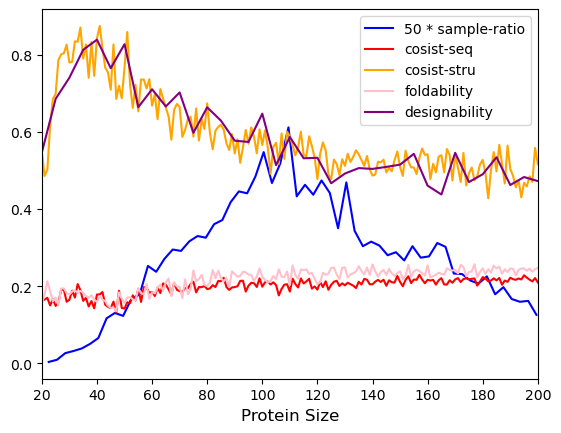

In [69]:
distribution_plot(result_dict)

### JointDiff-x

In [73]:
result_dict = results_load(
    path = '../../Results/Final/JointDiff-x/', 
    token = '_last'
)

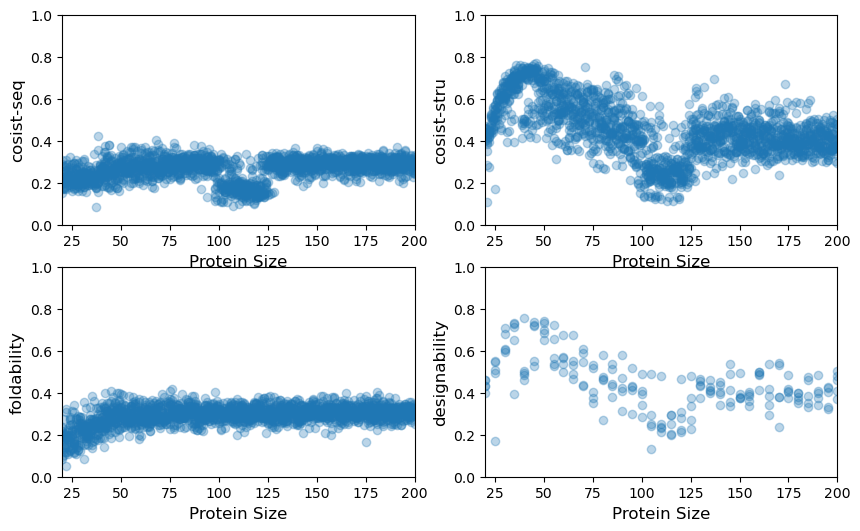

In [74]:
scatter_plot(result_dict)

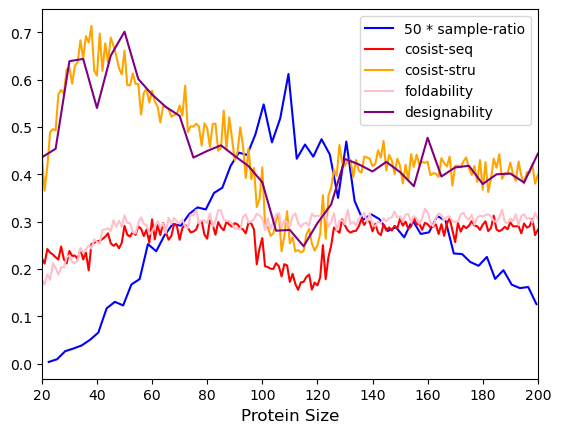

In [75]:
distribution_plot(result_dict)

### DiT

In [70]:
result_dict = results_load()

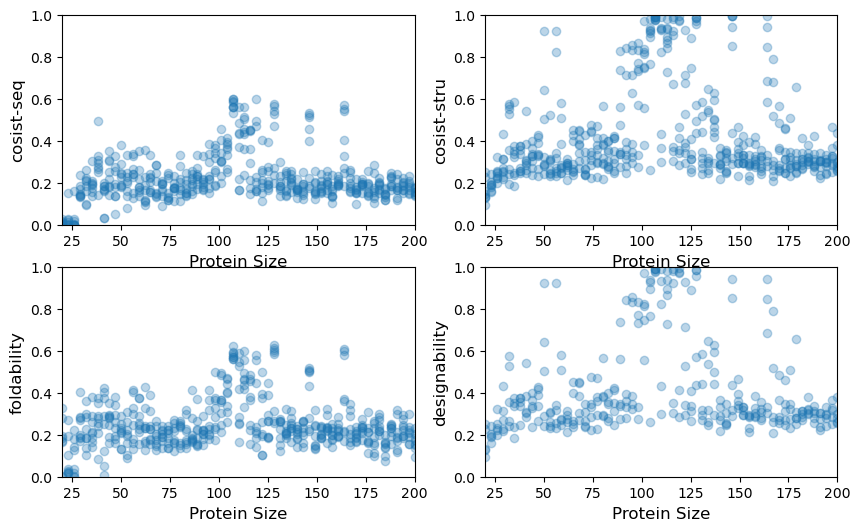

In [71]:
scatter_plot(result_dict)

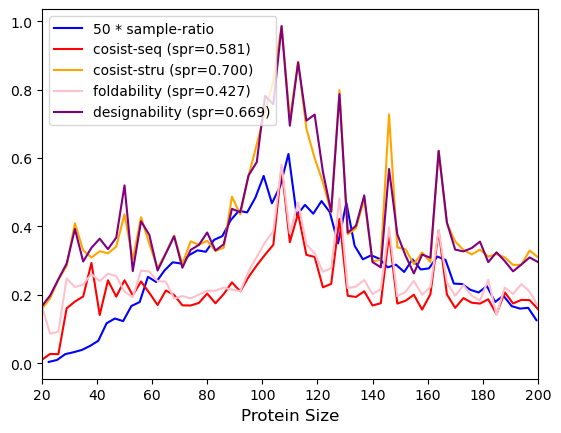

In [72]:
distribution_plot(result_dict)

In [118]:
result_dict = results_load(
    path = '../../Results/latentDiff_DiT/015-DiT-M-withLen-withMask_withLenClus_bin5/', 
    token = '_ddpm-uncon-guide_last'
)

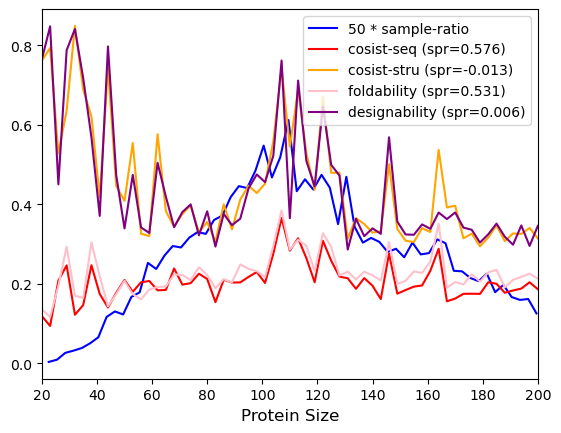

In [119]:
distribution_plot(result_dict)

## For data balance

In [81]:
sample_length = {}

for sample in length_dict:
    l = length_dict[sample]
    if l not in sample_length:
        sample_length[l] = set()
    sample_length[l].add(sample)

In [128]:
_ = dict_save(sample_length, '../../Data/Processed/CATH_cluster/length_cluster.pkl')

### different bins

In [143]:
for bin_size in [1, 5, 10, 20]:
    sample_length = {}
    sample_num = 0
    for sample in length_dict:
        l = length_dict[sample]
        if l < 20 or l > 200:
            continue

        if bin_size == 1:
            cate = l
        else:
            cate = (l - 1) // bin_size if l != 20 else 20 // bin_size
            cate_min = cate * bin_size if cate * bin_size == 20 else cate * bin_size + 1
            cate_max = (cate + 1) * bin_size
            cate = '%d~%d' % (cate_min, cate_max)
        
        if cate not in sample_length:
            sample_length[cate] = set()
        sample_length[cate].add(sample)
        sample_num += 1

    min_val = 100000
    max_val = 0
    for cate in sample_length:
        min_val = min(min_val, len(sample_length[cate]))
        max_val = max(max_val, len(sample_length[cate]))
    
    print('bin=%d' % bin_size)
    print('%d clusters; min=%d, max=%d; %d samples, %.2f per cluster; %d samples after upsampling' % (
        len(sample_length), min_val, max_val, sample_num, sample_num / len(sample_length), len(sample_length) * max_val
    ))
    
    #_ = dict_save(sample_length, '../../Data/Processed/CATH_cluster/length_cluster_bin%d.pkl' % bin_size)

bin=1
181 clusters; min=3, max=692; 50558 samples, 279.33 per cluster; 125252 samples after upsampling
bin=5
36 clusters; min=39, max=2866; 50558 samples, 1404.39 per cluster; 103176 samples after upsampling
bin=10
18 clusters; min=192, max=5292; 50558 samples, 2808.78 per cluster; 95256 samples after upsampling
bin=20
9 clusters; min=685, max=9833; 50558 samples, 5617.56 per cluster; 88497 samples after upsampling


In [144]:
sample_length.keys()

dict_keys(['61~80', '161~180', '41~60', '141~160', '101~120', '181~200', '81~100', '121~140', '20~40'])

In [147]:
for clus in sample_length:
    clus_list = [int(token) for token in clus.split('~')]
    clus_min = clus_list[0]
    clus_max = clus_list[1]
    
    for name in sample_length[clus]:
        l = length_dict[name]
        if l < clus_min or l > clus_max:
            print(name)

In [90]:
d = dict_load('../../Results/latentDiff_DiT/008-DiT-XL-withLen/loss.pkl')

In [91]:
d.keys()

dict_keys([10000, 15000, 20000, 25000])

([<matplotlib.patches.Wedge at 0x7f480ebfd610>,
 [Text(0.5230810831666973, 0.1699593493549404, 'JointDiff/JointDiff-x'),
  Text(-0.5499999999999994, -2.5747358111484747e-08, 'LaDiff/LaDiff-x'),
  Text(0.5230810990794377, -0.16995930038055432, 'others')],
 [Text(0.2853169544545622, 0.0927050996481493, '10%'),
  Text(-0.29999999999999966, -1.4044013515355315e-08, '80%'),
  Text(0.2853169631342387, -0.09270507293484781, '10%')])

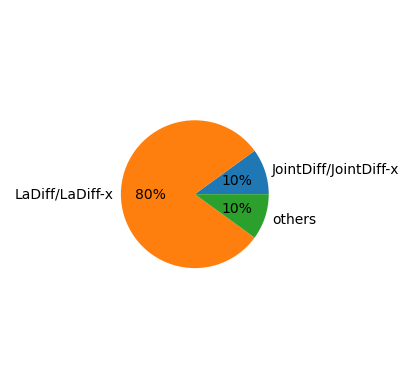

In [122]:
labels = 'JointDiff/JointDiff-x', 'LaDiff/LaDiff-x', 'others'
sizes = [10, 80, 10]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.f%%', radius=0.5) #textprops={'size': 'smaller'}, radius=0.5)
#plt.legend(fontsize = 10)

([<matplotlib.patches.Wedge at 0x7fcd764c0130>,
 [Text(3.367778697655222e-17, 0.55, 'Thesis'),
  Text(-1.0103336092965664e-16, -0.55, 'LaDiff/LaDiff-x')])

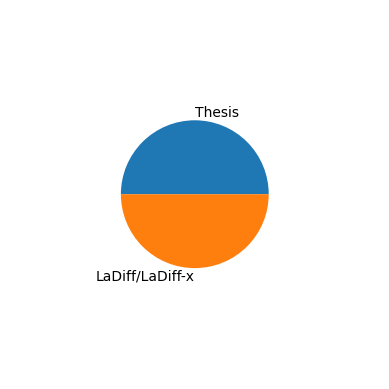

In [125]:
labels = ['Thesis', 'LaDiff/LaDiff-x']
sizes = [50, 50]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, radius=0.5) #, autopct='%1.f%%', radius=0.5) #textprops={'size': 'smaller'}, radius=0.5)
#plt.legend(fontsize = 10)

In [76]:
t = torch.load('../../Logs/logs_latentDiff_DiT/009-DiT-M-withLen-withMask_withLenClus/checkpoints/0005000.pt')

/tmp/ipykernel_177565/1361049358.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t = torch.load('../../Logs/logs_latentDiff_DiT/009-DiT-M-withLen-withMask_withLenClus/ch

In [80]:
t['args'].__contains__('cluster_dict')

True

In [95]:
d = dict_load('../../Results/latentDiff_DiT/010-DiT-M-withLen_withLenClus/consistency-seq_ddpm-uncon-guide_dict.pkl')

In [97]:
l_list = []
val_list = []
val_dict = {}

for sample in d:
    l = int(sample[3:].split('_')[0])
    l_list.append(l)
    val_list.append(np.mean(d[sample]))

for l, val in zip(l_list, val_list):
    if l not in val_dict:
        val_dict[l] = []
    val_dict[l].append(val)

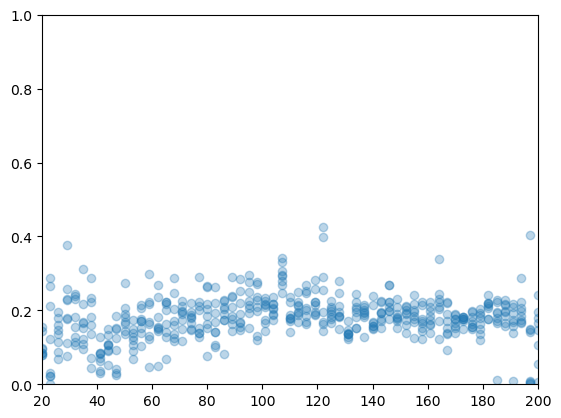

In [99]:
plt.figure()
plt.xlim(20, 200)
plt.ylim(0,1)
plt.scatter(l_list, val_list, alpha = 0.3)
plt.show()

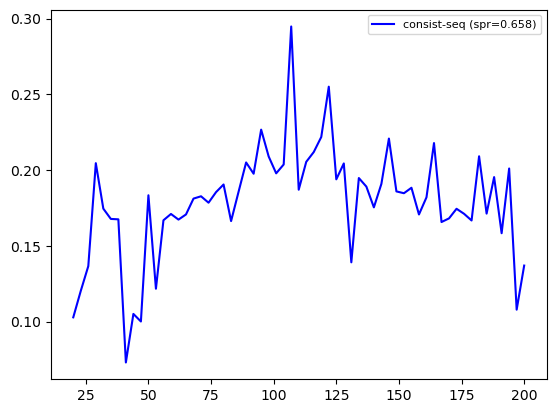

In [102]:
l_sort = sorted(val_dict.keys())
val_mean = [np.mean(val_dict[l]) for l in l_sort]
if len(val_mean[:-1]) == len(len_contour[0]):
    res = spearmanr(val_mean[:-1], len_contour[0])
    spr = res.statistic
    label = '%s (spr=%.3f)' % ('consist-seq', spr)
else:
    label = 'consist-seq'
    
plt.figure()
plt.plot(l_sort, val_mean, color = 'blue', label = label)
plt.legend(fontsize = 8)
plt.show()

In [150]:
sample = [1, 2, 3, 4]
np.random.choice(a=sample, size=12, replace=True)

array([2, 4, 2, 2, 4, 2, 3, 1, 2, 3, 2, 2])

In [151]:
d = dict_load('../../Results/autoencoder/embedding/autoencoder-simple_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd/111L_A1-162.pkl')

In [155]:
d['node']

array([[-7.32153797e+00, -4.63389206e+00,  1.38842974e+01, ...,
         5.84888315e+00,  5.10700750e+00,  5.61364937e+00],
       [ 1.09070778e+01,  6.15098763e+00,  1.72576237e+01, ...,
         7.84168053e+00,  2.79759192e+00,  2.32245946e+00],
       [-1.98316395e+00, -9.07974958e-01,  6.82662439e+00, ...,
        -1.13579903e+01, -2.60327744e+00,  1.24924622e+01],
       ...,
       [ 2.60818571e-01, -3.67720366e-01,  2.70096511e-01, ...,
         1.60063255e+00,  1.00095212e+00,  1.23479795e+00],
       [ 1.13844067e-01, -4.20297951e-01,  4.14172590e-01, ...,
         2.16491723e+00,  1.03380024e+00,  1.37967622e+00],
       [-1.17498524e-01, -4.49889570e-01,  3.45456600e-03, ...,
         2.23542571e+00,  8.75295341e-01,  1.19080949e+00]], dtype=float32)

In [159]:
d = dict_load('../../Results/autoencoder/ModalityRecovery/autoencoder-simple_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd/autoencoder-simple_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_test_epo45.pkl')

In [160]:
d.keys()

dict_keys(['id', 'od'])

In [163]:
d['od']['1A6C_A349-513']

{'SI': 0.4838709677419355, 'TM-score': 0.76508, 'RMSD': 3.19}

In [162]:
length_dict['1A6C_A349-513']

165

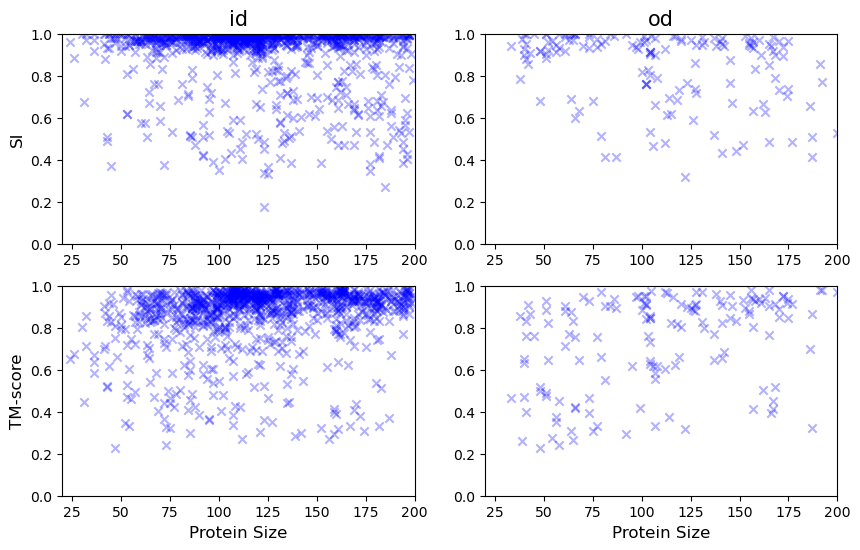

In [165]:
plt.figure(figsize = (10, 6))

for i,dset in enumerate(['id', 'od']):
    len_list = []
    SI_list = []
    TMscore_list = []

    for sample in d[dset]:
        len_list.append(length_dict[sample])
        SI_list.append(d[dset][sample]['SI'])
        TMscore_list.append(d[dset][sample]['TM-score'])

    for j, metric in enumerate(['SI', 'TM-score']):
        plt.subplot(2, 2, j * 2 + i + 1)
        plt.xlim(20, 200)
        plt.ylim(0, 1)

        y_list = SI_list if metric == 'SI' else TMscore_list
        plt.scatter(len_list, y_list, marker = 'x', alpha = 0.3, color = 'blue')
        if j == 0:
            plt.title(dset, fontsize = 15)
        if i == 0:
            plt.ylabel(metric, fontsize = 12)
        if j == 1:
            plt.xlabel('Protein Size', fontsize = 12)
plt.show()

In [177]:
l_set = set()

for sample in d:
    if sample not in length_dict:
        continue
    l = length_dict[sample]
    l_set.add(l)

In [180]:
for i in range(20, 201):
    if i not in l_set:
        print(i)

In [235]:
from Bio.PDB import PDBParser
from torch.utils.data import Dataset, DataLoader
import random

# Create a PDBParser object
parser = PDBParser()

In [214]:
ressymb_to_resindex = {
    'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4,
    'G': 5, 'H': 6, 'I': 7, 'K': 8, 'L': 9,
    'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14,
    'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19,
    'X': 20,
}

RESIDUE_dict = {'A':'ALA', 'R':'ARG', 'N':'ASN', 'D':'ASP', 'C':'CYS', 'Q':'GLN', 'E':'GLU',
                'G':'GLY', 'H':'HIS', 'I':'ILE', 'L':'LEU', 'K':'LYS', 'M':'MET', 'F':'PHE',
                'P':'PRO', 'S':'SER', 'T':'THR', 'W':'TRP', 'Y':'TYR', 'V':'VAL', 'B':'ASX',
                'Z':'GLX', 'X':'UNK'}

RESIDUE_reverse_dict = {}
for key, value in RESIDUE_dict.items():
    RESIDUE_reverse_dict[value] = key


In [215]:
restype_to_heavyatom_names = {
    'ALA': ['N', 'CA', 'C', 'O', 'CB', '',    '',    '',    '',    '',    '',    '',    '',    '', 'OXT'],
    'ARG': ['N', 'CA', 'C', 'O', 'CB', 'CG',  'CD',  'NE',  'CZ',  'NH1', 'NH2', '',    '',    '', 'OXT'],
    'ASN': ['N', 'CA', 'C', 'O', 'CB', 'CG',  'OD1', 'ND2', '',    '',    '',    '',    '',    '', 'OXT'],
    'ASP': ['N', 'CA', 'C', 'O', 'CB', 'CG',  'OD1', 'OD2', '',    '',    '',    '',    '',    '', 'OXT'],
    'CYS': ['N', 'CA', 'C', 'O', 'CB', 'SG',  '',    '',    '',    '',    '',    '',    '',    '', 'OXT'],
    'GLN': ['N', 'CA', 'C', 'O', 'CB', 'CG',  'CD',  'OE1', 'NE2', '',    '',    '',    '',    '', 'OXT'],
    'GLU': ['N', 'CA', 'C', 'O', 'CB', 'CG',  'CD',  'OE1', 'OE2', '',    '',    '',    '',    '', 'OXT'],
    'GLY': ['N', 'CA', 'C', 'O', '',   '',    '',    '',    '',    '',    '',    '',    '',    '', 'OXT'],
    'HIS': ['N', 'CA', 'C', 'O', 'CB', 'CG',  'ND1', 'CD2', 'CE1', 'NE2', '',    '',    '',    '', 'OXT'],
    'ILE': ['N', 'CA', 'C', 'O', 'CB', 'CG1', 'CG2', 'CD1', '',    '',    '',    '',    '',    '', 'OXT'],
    'LEU': ['N', 'CA', 'C', 'O', 'CB', 'CG',  'CD1', 'CD2', '',    '',    '',    '',    '',    '', 'OXT'],
    'LYS': ['N', 'CA', 'C', 'O', 'CB', 'CG',  'CD',  'CE',  'NZ',  '',    '',    '',    '',    '', 'OXT'],
    'MET': ['N', 'CA', 'C', 'O', 'CB', 'CG',  'SD',  'CE',  '',    '',    '',    '',    '',    '', 'OXT'],
    'PHE': ['N', 'CA', 'C', 'O', 'CB', 'CG',  'CD1', 'CD2', 'CE1', 'CE2', 'CZ',  '',    '',    '', 'OXT'],
    'PRO': ['N', 'CA', 'C', 'O', 'CB', 'CG',  'CD',  '',    '',    '',    '',    '',    '',    '', 'OXT'],
    'SER': ['N', 'CA', 'C', 'O', 'CB', 'OG',  '',    '',    '',    '',    '',    '',    '',    '', 'OXT'],
    'THR': ['N', 'CA', 'C', 'O', 'CB', 'OG1', 'CG2', '',    '',    '',    '',    '',    '',    '', 'OXT'],
    'TRP': ['N', 'CA', 'C', 'O', 'CB', 'CG',  'CD1', 'CD2', 'NE1', 'CE2', 'CE3', 'CZ2', 'CZ3', 'CH2', 'OXT'],
    'TYR': ['N', 'CA', 'C', 'O', 'CB', 'CG',  'CD1', 'CD2', 'CE1', 'CE2', 'CZ',  'OH',  '',    '', 'OXT'],
    'VAL': ['N', 'CA', 'C', 'O', 'CB', 'CG1', 'CG2', '',    '',    '',    '',    '',    '',    '', 'OXT'],
    'UNK': ['N', 'CA', 'C', 'O',  '',   '',    '',    '',    '',    '',    '',    '',    '',    '',    ''],
}

restype_to_heavyatom_order = {}

for resi in restype_to_heavyatom_names:
    restype_to_heavyatom_order[resi] = {}
    for i, atom in enumerate(restype_to_heavyatom_names[resi]):
        if atom == '':
            continue
        restype_to_heavyatom_order[resi][atom] = i
        

In [386]:
residue.get_id()

(' ', 158, ' ')

In [407]:
def pdb_info_read(pdb_path, chain_id):
    parser = PDBParser()
    structure = parser.get_structure("protein_name", pdb_path)
                
    model = structure[0]
    chain = model[chain_id]
    info_dict = {}
    resi_start = float('inf')
    
    for residue in chain:
        resi_idx = residue.get_id()[1]
        resi_name = residue.resname
        if resi_name not in RESIDUE_reverse_dict:
            continue
        resi_start = min(resi_start, resi_idx)
        resi_letter = RESIDUE_reverse_dict[resi_name]
        resi_val = ressymb_to_resindex[resi_letter]
        info_dict[resi_idx] = [resi_letter, resi_val]
        coor_resi = np.zeros((1, 15, 3))
        coor_mask = np.zeros((1, 15))
        
        for atom in residue:
            atom_name = atom.get_name()
            if atom_name not in restype_to_heavyatom_order[resi_name]:
                continue
            atom_idx = restype_to_heavyatom_order[resi_name][atom_name]
            coor_resi[0, atom_idx] = atom.get_coord()
            coor_mask[0, atom_idx] = 1
        info_dict[resi_idx].append(coor_resi)
        info_dict[resi_idx].append(coor_mask)

    ###### summarization ######
    seq = ''
    seq_array = []
    coor_mat = []
    atom_mask = []
    for resi_idx in sorted(info_dict):
        seq += info_dict[resi_idx][0]
        seq_array.append(info_dict[resi_idx][1])
        coor_mat.append(info_dict[resi_idx][2])
        atom_mask.append(info_dict[resi_idx][3])
    
    return np.vstack(coor_mat), np.array(seq_array), seq, np.vstack(atom_mask), resi_start

In [391]:
pdb = '../../Data/Origin/motif-scaffolding_benchmark/pdb_processed/1BCF.pdb'
coor_mat, seq_array, seq, atom_mask, resi_start = pdb_info_read(pdb_file, 'A')

NameError: name 'pdb_file' is not defined

In [230]:
atom_mask[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
['1', '1BCF', '8-15,A92-99,16-30,A123-130,16-30,A47-54,16-30,A18-25,8-15', '96-152']

In [382]:
def motif_shape_sele(motif_region, length_set):
    motif_region = motif_region.split(',')
    size_sele = []
    flag_list = []
    size_all = 0
    sele_region = []
    
    for size in motif_region:
        flag = size[0] in '1234567890'
        flag_list.append(flag)
            
        if flag: ### sample region
            size = size.split('-')
            size = (int(size[0]), int(size[1]))
            ### select the smallest size first
            size_all += size[0]
            size_sele.append(size[0])
            ### maximum added length
            sele_region.append(size[1] - size[0])
            
        else: ### motif_region
            size = size[1:]
            size = size.split('-')
            size = (int(size[0]) - 1, int(size[1]))
            size_sele.append(size)
            size_all += (size[1] - size[0])
            sele_region.append(None)

    ### extend the sequence
    size_all_list = range(max(size_all, length_set[0]), length_set[-1] + 1)
    length_sele = random.choice(size_all_list)
    length_add = length_sele - size_all

    if length_add == 0:
        return size_sele, size_all

    idx = 0
    while idx == 0 or size_all < length_set[0]:
        for i, flag in enumerate(flag_list):
            if flag:
                add_range = sele_region[i]
                l_add = random.choice(range(min(add_range, length_add) + 1))
                sele_region[i] -= l_add
                size_sele[i] += l_add
                length_add -= l_add
                size_all += l_add
                if length_add == 0:
                    break
        idx += 1
        if idx > 10:
            print('Contradictory case: %s, %s!' % (motif_region, length_set))
            break
    
    return size_sele, size_all

In [301]:
motif_shape_sele('8-15,A92-99,16-30,A123-130,16-30,A47-54,16-30,A18-25,8-15', [96, 152])

([9, (91, 99), 24, (122, 130), 21, (46, 54), 24, (17, 25), 8], 118)

In [430]:
class MotifScaffoldingDataset(Dataset):
    def __init__(self, 
        info_path = '../../Data/Origin/motif-scaffolding_benchmark/benchmark.csv', 
        pdb_path = '../../Data/Origin/motif-scaffolding_benchmark/pdbs_processed/',
        info_dict_path = '../../Data/Origin/motif-scaffolding_benchmark/benchmark_data.pkl',
        with_frag = True, force_cover = False
    ):
        
        self.with_frag = with_frag

        if os.path.exists(info_dict_path) and (not force_cover):
            self.info_dict = dict_load(info_dict_path)
            self.max_size = self.info_dict['max_size']
            del self.info_dict['max_size']
            self.name_list = list(self.info_dict.keys())
            
        else:
            self.info_dict = {}
            self.name_list = []
            self.max_size = 0
            
            with open(info_path, 'r') as rf:
                for i,line in enumerate(rf):
                    if i == 0:
                        continue
                    line = line.strip('\n').split("\"")
                    line = [token for token in line[0].split(',') + [line[1]] + line[2].split(',') if token != '']
            
                    name = line[1]
                    pdb = name.split('_')[0]
                    pdb_file = os.path.join(pdb_path, '%s.pdb' % pdb)
                
                    if not os.path.exists(pdb_file):
                        print('%s not found!' % pdb_file)
                        continue
    
                    try:
                        ### region
                        motif_region = line[2]                
                        length = line[3]
                        if '-' in length:
                            length = length.split('-')
                            length_list = list(range(int(length[0]), int(length[1]) + 1))
                        else:
                            length = int(length)
                            length_list = list(range(length, length + 1))
                        self.max_size = max(self.max_size, length_list[-1])
        
                        ### pdb info
                        for token in motif_region.split(','):
                            if token[0] not in '0123456789':
                                chain_id = token[0]
                                break
                        coor_mat, seq_array, seq, atom_mask, resi_start = pdb_info_read(pdb_file, chain_id)
        
                        ### save 
                        self.name_list.append(name)
                        self.info_dict[name] = {
                            'coor': coor_mat, 'seq_array': seq_array, 'seq': seq, 'atom_mask': atom_mask,
                            'motif_region': motif_region, 'length_set': length_list, 'resi_start': resi_start, 
                        }
                    except Exception as e:
                        print(name, e)

            self.info_dict['max_size'] = self.max_size
            _ = dict_save(self.info_dict, info_dict_path)

        print('%d entries loaded. max_length=%d' %(self.__len__(), self.max_size))

    def __len__(self):
        return len(self.name_list)

    def __getitem__(self, idx):
        """
        Output:
            aa: amino acid sequence; (N, L)
            pos_heavyatom: heavy atom coordinates; float; (N, L, atom_num = 15; 3)
            mask_heavyatom: heavy atom mask, bool; (N, L, atom_num = 15)
            mask_res: residue mask; (N, L)
            mask_gen: design region; (N, L)
            chain_nb: chain idx; 0 for padding; (N, L)
            res_nb: residue idx, start from 1; (N, L)
            fragment_type: 1 for design region, 2 for context (if with_frag), 0 for padding; (N,L)
        """

        name = self.name_list[idx]
        
        ###### info ######
        data_info = self.info_dict[name]
        coor_mat = data_info['coor']
        seq_array = data_info['seq_array']
        seq = data_info['seq']
        atom_mask = data_info['atom_mask']
        size_sele, _ = motif_shape_sele(data_info['motif_region'], data_info['length_set'])
        resi_start = data_info['resi_start']
        # [int, tuple, int, ...]

        ###### features ######
        aa = []
        pos_heavyatom = []
        mask_heavyatom = []
        mask_gen = []
        fragment_type = []
        for size in size_sele:
            ### for design
            if isinstance(size, int):
                aa.append(np.ones(size) * 20)
                pos_heavyatom.append(np.zeros([size, 15, 3]))
                mask_atom = np.zeros([size, 15])
                mask_atom[:,:4] = 1
                mask_heavyatom.append(mask_atom)
                mask_gen.append(np.ones(size))
                fragment_type.append(np.ones(size))
            ### for motif
            else:
                start = size[0] - resi_start + 1
                end = size[1] - resi_start + 1
                seq_add = seq_array[start: end]
                if seq_add.shape[0] != end - start:
                    print('Warning! Missing residues in [%d, %d) of %s! (resi_start=%d)' % (start, end, name, resi_start))
                aa.append(seq_add)
                pos_heavyatom.append(coor_mat[start: end])
                mask_heavyatom.append(atom_mask[start: end])
                mask_gen.append(np.zeros(seq_add.shape))
                if self.with_frag:
                    fragment_type.append(np.ones(seq_add.shape) * 2)
                else:
                    fragment_type.append(np.ones(seq_add.shape))

        ### summary 
        out = {'name': name}
        out['aa'] = np.hstack(aa)
        out['pos_heavyatom'] = np.vstack(pos_heavyatom)
        out['mask_heavyatom'] = (np.vstack(mask_heavyatom) == 1)
        out['mask_gen'] = (np.hstack(mask_gen) == 1)
        out['fragment_type'] = np.hstack(fragment_type)
        out['length'] = out['aa'].shape[0]
        out['chain_nb'] = np.ones(out['length'])
        out['res_nb'] = np.arange(1, out['length'] + 1)
        out['mask_res'] = (np.ones(out['length']) == 1)

        length_pad = self.max_size - out['length']
        if length_pad > 0:
            for key in out:
                if key == 'name' or key == 'length':
                    continue
                pad_shape = [length_pad]
                for s in out[key].shape[1:]:
                    pad_shape.append(s)
                mat_pad = np.zeros(pad_shape)

                if len(out[key].shape) == 1:
                    out[key] = np.hstack([out[key], mat_pad])
                else:
                    out[key] = np.vstack([out[key], mat_pad])
                
        return out


In [431]:
dataset = MotifScaffoldingDataset()
data_loader = DataLoader(
        dataset,
        batch_size=2,
        shuffle=False,
        num_workers=1,
    )

24 entries loaded. max_length=152


In [427]:
for batch in data_loader:
    print(batch.keys())

dict_keys(['name', 'aa', 'pos_heavyatom', 'mask_heavyatom', 'mask_gen', 'fragment_type', 'length', 'chain_nb', 'res_nb', 'mask_res'])
dict_keys(['name', 'aa', 'pos_heavyatom', 'mask_heavyatom', 'mask_gen', 'fragment_type', 'length', 'chain_nb', 'res_nb', 'mask_res'])
dict_keys(['name', 'aa', 'pos_heavyatom', 'mask_heavyatom', 'mask_gen', 'fragment_type', 'length', 'chain_nb', 'res_nb', 'mask_res'])
dict_keys(['name', 'aa', 'pos_heavyatom', 'mask_heavyatom', 'mask_gen', 'fragment_type', 'length', 'chain_nb', 'res_nb', 'mask_res'])
dict_keys(['name', 'aa', 'pos_heavyatom', 'mask_heavyatom', 'mask_gen', 'fragment_type', 'length', 'chain_nb', 'res_nb', 'mask_res'])
dict_keys(['name', 'aa', 'pos_heavyatom', 'mask_heavyatom', 'mask_gen', 'fragment_type', 'length', 'chain_nb', 'res_nb', 'mask_res'])
dict_keys(['name', 'aa', 'pos_heavyatom', 'mask_heavyatom', 'mask_gen', 'fragment_type', 'length', 'chain_nb', 'res_nb', 'mask_res'])
dict_keys(['name', 'aa', 'pos_heavyatom', 'mask_heavyatom', 'm

In [428]:
batch

{'name': ['6EXZ_med', '6EXZ_long'],
 'aa': tensor([[20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
          20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,  9.,  3., 16.,  8.,
           9., 11.,  0.,  3., 19., 16.,  4., 10.,  9.,  0.,  3., 20., 20., 20.,
          20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
          20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
          20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       

In [284]:
path

'../../Data/Origin/motif-scaffolding_benchmark/benchmark.csv'

In [422]:
with open(path, 'r') as rf, open('/scratch/user/shaowen1994/SOTA_models/StrucDesign/RFdiffusion/modif_scaffolding_test_2.sh', 'w') as wf:
    for i,line in enumerate(rf):
        if i == 0:
            continue
        line = line.strip('\n').split("\"")
        line = [token for token in line[0].split(',') + [line[1]] + line[2].split(',') if token != '']
        print(line)

        name = line[1]
        pdb = name.split('_')[0]
        motif = '/'.join(line[2].split(','))
        if '-' in line[-1]:
            length = line[-1]
        else:
            length = '%s-%s' % (line[-1], line[-1])

        command = "./scripts/run_inference.py \
'contigmap.contigs=[%s]' \
inference.output_prefix=tests/motif_scaffolding/%s inference.num_designs=100 \
inference.input_pdb=/scratch/user/shaowen1994/DiffCodesign_local/Data/Origin/motif-scaffolding_benchmark/pdbs_processed/%s.pdb \
'contigmap.length=%s'\n\n" %(motif, name, pdb, length)

        wf.write(command)

['0', '1PRW', '5-20,A16-35,10-25,A52-71,5-20', '60-105']
['1', '1BCF', '8-15,A92-99,16-30,A123-130,16-30,A47-54,16-30,A18-25,8-15', '96-152']
['2', '5TPN', '10-40,A163-181,10-40', '50-75']
['3', '5IUS', '0-30,A119-140,15-40,A63-82,0-30', '57-142']
['4', '3IXT', '10-40,C254-277,10-40', '50-75']
['5', '5YUI', '5-30,A93-97,5-20,A118-120,10-35,A198-200,10-30', '50-100']
['6', '1QJG', '10-20,A38-38,15-30,A14-14,15-30,A99-99,10-20', '53-103']
['8', '1YCR', '10-40,B19-27,10-40', '40-100']
['13', '2KL8', 'A1-7,20-20,A28-79', '79']
['14', '7MRX_60', '0-38,B25-46,0-38', '60']
['15', '7MRX_85', '0-63,B25-46,0-63', '85']
['16', '7MRX_128', '0-122,B25-46,0-122', '128']
['17', '4JHW', '10-25,F196-212,15-30,F63-69,10-25', '60-90']
['18', '4ZYP', '10-40,A422-436,10-40', '30-50']
['19', '5WN9', '10-40,A170-189,10-40', '35-50']
['21', '5TRV_short', '0-35,A45-65,0-35', '56']
['22', '5TRV_med', '0-65,A45-65,0-65', '86']
['23', '5TRV_long', '0-95,A45-65,0-95', '116']
['24', '6E6R_short', '0-35,A23-35,0-35'

In [433]:
model = torch.load('../../Logs/logs_originDiff/codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__08_08_06_loss-0-mse-0-0_rm/checkpoints/122000.pt')

/tmp/ipykernel_177565/2053366554.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('../../Logs/logs_originDiff/codesign_diffab_complete_gen_share-true_d

In [436]:
model.keys()

dict_keys(['config', 'model', 'optimizer', 'scheduler', 'iteration', 'avg_val_loss'])

In [444]:
d = dict_load('../../../BioML/result/codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale50.0_2024_09_29__00_34_52_withEpi/eval_sample_1.pkl')

In [447]:
list(d.keys())[:10]

['5x68',
 '4j34',
 '2nm2',
 '5f3m',
 '2nnl',
 '4pvc',
 '4r1s',
 '4r1u',
 '5tqm',
 '1ujm']

In [449]:
d['5x68']

{0: {'SI': 0.046263345195729534, 'rmsd': 121.74504852294922},
 1: {'SI': 0.046263345195729534, 'rmsd': 122.57505798339844}}

In [450]:
d2 = dict_load('../../../BioML/result_final/SelfCondi_RandomMask_AFM-loss_Monomer/eval_CAR_sample_10.pkl')

In [451]:
list(d2.keys())[:10]

['sequence_2_ranked_0.pdb_A_B_74-80',
 'sequence_2_ranked_0.pdb_A_B_74-80_att1',
 'sequence_2_ranked_0.pdb_A_B_146-160',
 'sequence_2_ranked_0.pdb_A_B_146-160_att1',
 'sequence_2_ranked_0.pdb_A_B_168-175',
 'sequence_2_ranked_0.pdb_A_B_168-175_att1',
 'sequence_2_ranked_0.pdb_A_B_74-175-union',
 'sequence_2_ranked_0.pdb_A_B_74-175-union_att1',
 'sequence_2_ranked_0.pdb_A_B_72-188',
 'sequence_2_ranked_0.pdb_A_B_72-188_att1']

In [483]:
def rmsd_dict_read(d):
    out = {}
    for sample in d:
        for step in d[sample]:
            if step not in out:
                out[step] = {'SI':[], 'rmsd':[]}
            if not ('SI' in d[sample][step] and 'rmsd' in d[sample][step]):
                continue
            for metric in ['SI', 'rmsd']:
                out[step][metric].append(d[sample][step][metric])
    return out

In [452]:
d2['sequence_2_ranked_0.pdb_A_B_74-80']

{0: {'rmsd': 10.019730567932129,
  'rmsd-CA': 10.06894302368164,
  'SR': 0.0759493670886076,
  'SI_align': 0.1125,
  'contact_num': 46,
  'epi_contact_num': 2}}

In [484]:
result_all = {}

with open('binder_design_list.txt', 'r') as rf:
    for line in rf:
        path = line.strip('\n')
        model = path.split('/')[-2]
        if model not in result_all:
            print(model)
            result_all[model] = {}
        version = path.split('/')[-1][:-3]
        #if 'finetune' in version:
        #    continue
        result_all[model][version] = rmsd_dict_read(dict_load(path))
        # print(line)
        #d = dict_load()

codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale10.0_2024_09_29__00_34_52_withEpi-withSite
codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale10.0_2024_09_29__00_34_52_withEpi-withSite-withMono
codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale10.0_2024_09_30__14_27_48_inter_withEpi-withSite
codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale50.0_2024_09_29__00_34_52_noEpi
codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale50.0_2024_09_29__00_34_52_noEpi-withSfold
codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale50.0_2024_09_29__00_34_52_withEpi
codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale50.0_2024_09_29__00_34_52_withEpi-withSite
codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale50.0_2024_09_29__00_34_52_withEpi-withSite-withMono
codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale50.0_2024_09_29__00_34_52_withEpi-withSite-withSfold
codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale50.0_2024_09_29__00_34_52_withEpi-withSite-withSfold-withMono
codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale50.0_2024_

In [488]:
step = 0

for model in result_all:
    print(model)
    print('********************************')

    for version in result_all[model]:
        print('%s: rmsd=%.4f; SI=%.4f' % (
            version, 
            np.mean([val for val in result_all[model][version][step]['rmsd'] if not np.isnan(val)]), 
            np.mean(result_all[model][version][step]['SI']), 
        ))
    
    print()

codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale10.0_2024_09_29__00_34_52_withEpi-withSite
********************************
eval_sample_1_all.: rmsd=190.1820; SI=0.0622
eval_sample_1.: rmsd=184.8859; SI=0.0615
eval_sample_2_all.: rmsd=188.8167; SI=0.0639
eval_sample_2.: rmsd=181.9782; SI=0.0642

codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale10.0_2024_09_29__00_34_52_withEpi-withSite-withMono
********************************
eval_sample_1_all.: rmsd=216.1083; SI=0.0631
eval_sample_1.: rmsd=209.6275; SI=0.0628
eval_sample_2_all.: rmsd=215.6120; SI=0.0589
eval_sample_2.: rmsd=211.4437; SI=0.0594

codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale10.0_2024_09_30__14_27_48_inter_withEpi-withSite
********************************
eval_sample_1_all.: rmsd=200.1954; SI=0.0572
eval_sample_1.: rmsd=195.6819; SI=0.0562
eval_sample_2_all.: rmsd=202.4612; SI=0.0571
eval_sample_2.: rmsd=196.8911; SI=0.0580

codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale50.0_2024_09_29__00_34_52_noEpi
**************

In [491]:
step = 1

for model in result_all:
    print(model)
    print('********************************')

    for version in result_all[model]:
        if step not in result_all[model][version]:
            continue
        print('%s: rmsd=%.4f; SI=%.4f' % (
            version, 
            np.mean([val for val in result_all[model][version][step]['rmsd'] if not np.isnan(val)]), 
            np.mean(result_all[model][version][step]['SI']), 
        ))
    
    print()

codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale10.0_2024_09_29__00_34_52_withEpi-withSite
********************************
eval_sample_1_all.: rmsd=190.1228; SI=0.0622
eval_sample_1.: rmsd=184.8287; SI=0.0615
eval_sample_2_all.: rmsd=188.7582; SI=0.0639
eval_sample_2.: rmsd=181.9227; SI=0.0642

codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale10.0_2024_09_29__00_34_52_withEpi-withSite-withMono
********************************
eval_sample_1_all.: rmsd=216.0389; SI=0.0631
eval_sample_1.: rmsd=209.5612; SI=0.0627
eval_sample_2_all.: rmsd=215.5427; SI=0.0589
eval_sample_2.: rmsd=211.3761; SI=0.0594

codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale10.0_2024_09_30__14_27_48_inter_withEpi-withSite
********************************
eval_sample_1_all.: rmsd=200.1429; SI=0.0572
eval_sample_1.: rmsd=195.6320; SI=0.0561
eval_sample_2_all.: rmsd=202.4077; SI=0.0571
eval_sample_2.: rmsd=196.8404; SI=0.0580

codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale50.0_2024_09_29__00_34_52_noEpi
**************

In [489]:
result_all[model][version][step]['rmsd']

[]

In [475]:
version

'eval_sample_1_all.'

In [479]:
path = '../../../BioML/result/codesign_dim-128_step100_lr1.e-4_wd0.0_posiscale50.0_sc_2024_10_04__14_19_11_withEpi-withSite_with-center-clash_cenLoss_clash_af3relpos/eval_finetune_sample_1.pkl'

In [480]:
d = dict_load(path)

In [482]:
d['2OSL_P_H']

{0: {'rmsd': 11.116181373596191,
  'rmsd-CA': 11.171284675598145,
  'SR': 0.0547945205479452,
  'SI_align': 0.08641975308641975}}

In [513]:
#d = dict_load('../../Results/latentDiff/latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2_withMask_noise_len-mha_Faster_100steps_micro/consistency-seq_dict.pkl')
d = dict_load('../../Results/latentDiff/latentdiff_with-ESM-IF_joint-mlp-4-512_pad-zero_dim16_vae-0.001_NoEnd_unet-2_withMask_noise_len-linear_Faster_100steps_micro/consistency-seq_dict.pkl')

In [514]:
d['len125_step0_3']

[0.39705882352941174,
 0.15827338129496402,
 0.08450704225352113,
 0.13768115942028986,
 0.07792207792207792,
 0.1223021582733813,
 0.21014492753623187,
 0.09420289855072464,
 0.34558823529411764,
 0.11428571428571428]

In [515]:
val = []

for sample in d:
    val.append(np.mean(d[sample]))

print(np.mean(val))

0.11342271597857571


In [509]:
val = []

for sample in d:
    val_temp = []
    
    for design in d[sample]:
        val_temp.append(d[sample][design][0])
    val.append(np.mean(val_temp))

print(np.mean(val))

0.20361782786885246


In [5]:
path = '../../Results/jointDiff_motif/'

In [6]:
m_list = os.listdir(path)

In [7]:
raw_result = {}
for m in m_list:
    d_path = os.path.join(path, m, 'designability_esmfold_TMscore_dict.pkl')
    if os.path.exists(d_path):
        print(m)
        raw_result[m] = dict_load(d_path)
    

codesign_diffab_complete_gen_share-true_dim-256-128-2_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_24__20_48_33_loss-1-mse-1-1_rm_mse
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_center_2024_10_22__08_09_49_loss-0-mse-0-0_rm
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_24__20_48_33_loss-1-mse-1-1_rm_mse
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__08_08_06_loss-0-mse-0-0_rm


In [8]:
raw_result['RFdiffusion'] = dict_load('../../Results/Baseline_motif/RFdiffusion/designability_esmfold_TMscore_dict.pkl')

In [9]:
for m in raw_result:
    val_1 = []
    val_2 = []
    
    d = raw_result[m]
    for sample in d:
        val_temp_1 = []
        val_temp_2 = []
        
        for design in d[sample]:
            val_temp_1.append(d[sample][design][0])
            val_temp_2.append(d[sample][design][1])
        val_1.append(np.mean(val_temp_1))
        val_2.append(np.mean(val_temp_2))

    print(m, np.mean(val_1), np.mean(val_2))

codesign_diffab_complete_gen_share-true_dim-256-128-2_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_24__20_48_33_loss-1-mse-1-1_rm_mse 0.46958653749999996 2.9208729166666663
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_center_2024_10_22__08_09_49_loss-0-mse-0-0_rm 0.45451792361111115 2.950771527777778
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_24__20_48_33_loss-1-mse-1-1_rm_mse 0.46269053125 2.9544298611111115
codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_22__08_08_06_loss-0-mse-0-0_rm 0.45451792361111115 2.950771527777778
RFdiffusion 0.7924879316666666 1.4964383333333333


In [16]:
for m in raw_result:

    task_dict = {}    
    d = raw_result[m]
    for sample in d:
        if 'RFdiffusion' in m:
            task = '_'.join(sample.split('_')[:-1])
        else:
            task = '_'.join(sample.split('_')[:-2])
        if task not in task_dict:
            task_dict[task] = [0, 0]

        task_dict[task][0] += 1
        
        for design in d[sample]:
            rmsd = d[sample][design][1]
            if rmsd <= 2:
                task_dict[task][1] += 1
            break
            
    print(m)
    print('%d tasks' % len(task_dict))
    suc_num = 0
    r_list = []
    r_dict = {}
    for task in task_dict:
        if task_dict[task][1] > 0:
            suc_num += 1
        ratio = task_dict[task][1] / task_dict[task][0]
        r_list.append(ratio)
        r_dict[task] = ratio

    print('%d succ samples. %f' % (suc_num, np.mean(r_list)))
    print(r_dict)

    print()

codesign_diffab_complete_gen_share-true_dim-256-128-2_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_24__20_48_33_loss-1-mse-1-1_rm_mse
24 tasks
20 succ samples. 0.177500
{'5TRV_short': 0.11, '5TPN': 0.05, '1QJG': 0.02, '5YUI': 0.01, '6E6R_med': 0.05, '7MRX_85': 0.03, '3IXT': 0.09, '5TRV_med': 0.0, '4JHW': 0.01, '2KL8': 0.96, '7MRX_60': 0.08, '5WN9': 0.04, '1YCR': 0.28, '4ZYP': 0.31, '6EXZ_long': 0.03, '7MRX_128': 0.0, '1BCF': 0.68, '6E6R_short': 0.14, '5IUS': 0.0, '5TRV_long': 0.02, '1PRW': 0.79, '6EXZ_med': 0.12, '6E6R_long': 0.0, '6EXZ_short': 0.44}

codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_center_2024_10_22__08_09_49_loss-0-mse-0-0_rm
24 tasks
22 succ samples. 0.147500
{'5TRV_short': 0.14, '5TPN': 0.11, '1QJG': 0.02, '5YUI': 0.0, '6E6R_med': 0.02, '7MRX_85': 0.02, '3IXT': 0.08, '5TRV_med': 0.03, '4JHW': 0.03, '2KL8': 0.99, '7MRX_60': 0.1, '5WN9': 0.03, '1YCR': 0.17, '4ZYP': 0.07, '6EXZ_long': 0.01, '7MRX_128': 0.0, '1BCF': 0.36, 

In [17]:
sele_task = {'5TPN',
'3IXT',
'1YCR',
'2KL8',
'7MRX_60',
'7MRX_85',
'7MRX_128',
'4ZYP',
'5WN9',
'5TRV_short',
'5TRV_med',
'5TRV_long',
'6E6R_short',
'6E6R_med',
'6E6R_long',
'6EXZ_short',
'6EXZ_med',
'6EXZ_long',}

In [18]:
for m in raw_result:

    task_dict = {}    
    d = raw_result[m]
    for sample in d:
        if 'RFdiffusion' in m:
            task = '_'.join(sample.split('_')[:-1])
        else:
            task = '_'.join(sample.split('_')[:-2])
        if task not in task_dict:
            task_dict[task] = [0, 0]

        task_dict[task][0] += 1
        
        for design in d[sample]:
            rmsd = d[sample][design][1]
            if rmsd <= 2:
                task_dict[task][1] += 1
            break
            
    print(m)
    
    suc_num = 0
    r_list = []
    r_dict = {}

    task_num = set()
    for task in task_dict:
        if task not in sele_task:
            continue
        task_num.add(task)
        if task_dict[task][1] > 0:
            suc_num += 1
        ratio = task_dict[task][1] / task_dict[task][0]
        r_list.append(ratio)
        r_dict[task] = ratio

    print('%d tasks' % len(task_num))
    print('%d succ samples. %f' % (suc_num, np.mean(r_list)))
    print(r_dict)

    print()

codesign_diffab_complete_gen_share-true_dim-256-128-2_step100_lr1.e-4_wd0._posiscale50.0_sc_center_2024_10_24__20_48_33_loss-1-mse-1-1_rm_mse
18 tasks
15 succ samples. 0.152778
{'5TRV_short': 0.11, '5TPN': 0.05, '6E6R_med': 0.05, '7MRX_85': 0.03, '3IXT': 0.09, '5TRV_med': 0.0, '2KL8': 0.96, '7MRX_60': 0.08, '5WN9': 0.04, '1YCR': 0.28, '4ZYP': 0.31, '6EXZ_long': 0.03, '7MRX_128': 0.0, '6E6R_short': 0.14, '5TRV_long': 0.02, '6EXZ_med': 0.12, '6E6R_long': 0.0, '6EXZ_short': 0.44}

codesign_diffab_complete_gen_share-true_dim-128-64-4_step100_lr1.e-4_wd0._posiscale50.0_center_2024_10_22__08_09_49_loss-0-mse-0-0_rm
18 tasks
17 succ samples. 0.135000
{'5TRV_short': 0.14, '5TPN': 0.11, '6E6R_med': 0.02, '7MRX_85': 0.02, '3IXT': 0.08, '5TRV_med': 0.03, '2KL8': 0.99, '7MRX_60': 0.1, '5WN9': 0.03, '1YCR': 0.17, '4ZYP': 0.07, '6EXZ_long': 0.01, '7MRX_128': 0.0, '6E6R_short': 0.26, '5TRV_long': 0.03, '6EXZ_med': 0.11, '6E6R_long': 0.01, '6EXZ_short': 0.25}

codesign_diffab_complete_gen_share-true_d

In [22]:
import torch.nn as nn
from typing import List

In [23]:
class Net(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, h_dims: List[int], n_frequencies:int) -> None:
        super().__init__()

        ins = [in_dim + 2 * n_frequencies] + h_dims
        outs = h_dims + [out_dim]
        self.n_frequencies = n_frequencies

        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(in_d, out_d), nn.LeakyReLU()) for in_d, out_d in zip(ins, outs)
        ])
        self.top = nn.Sequential(nn.Linear(out_dim, out_dim))

    def time_encoder(self, t: torch.Tensor) -> torch.Tensor:
        freq = 2 * torch.arange(self.n_frequencies, device=t.device) * torch.pi
        t = freq * t[..., None]
        return torch.cat((t.cos(), t.sin()), dim=-1)

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        t = self.time_encoder(t)
        x = torch.cat((x, t), dim=-1)

        for l in self.layers:
          x = l(x)
        return self.top(x)

In [24]:
net = Net(2, 2, [512]*5, 10)

In [28]:
t = torch.ones(4, 1)
x = torch.randn(4, 6, 3)

In [31]:
out = net(t, x)

RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 6 but got size 1 for tensor number 1 in the list.

In [ ]:
out.shape